Analyzing the code from the other notebooks of this gitHub, there might be a confussion between the different results obtained and the code used. This notebook will try to get an overview of the different available methods and try to choose the best one for the CFD application of the multiobjective optimization problem. The methods here described will be:
* Random search (which will be shortened as RS)
* Genetic algorithm with roulette selection method (shortened as GA_E)
* NSGA II implementation (labeled as NSGA-II)

This notebook is divided in:
* Function declaration and definition
    * Monte Carlo or Random search method
    * General Genetic Algorithm with elitism
    * Non-dominated Sorting Genetic Algorithm II
* Example optimization with MC, GA_E, NSGA-II
* Three functions will be tested (Bihn & Korn, Poloni, ZDT2), following:
    * Comparison of the three methods for just one run
    * Histogram with the location of the points along different runs
    * Generations and individuals trade-off (generation and data saving)
* Load the generations and individuals trade-off analysis and generate the figures

In [1]:
%matplotlib inline
#Importing required modules
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import cm
import random
import scipy.stats as stats
import warnings
from matplotlib.colors import LogNorm
from prettytable import PrettyTable
import optunity
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.style.use('seaborn-deep')
plt.style.use('classic')
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler('color', ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9'])
matplotlib.rcParams['axes.linewidth'] = 1.3
matplotlib.rcParams['lines.linewidth'] = 1.3
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
matplotlib.rcParams.update({'font.size': 8})

# 1. Algorithms definition

## 1.1 Random search algorithm (RS)
The random search method consists in just giving a set of random points to get the value and hope they give a good approximation of the Pareto front. 

In [3]:
def RS(N):
    '''
    Random search method
    
    INPUTS:
    N:           integer number with the number of individuals
    
    OUTPUTS:    
    points:      numpy.ndarray with all the random initialized points
    funEval:     numpy.ndarray with the evaluation of points
    fun.counter: number of callings to the funtion (although it will 
                 match N, it is kept for parallelism)
    
    This function simply evaluates a random initializated set of N points
    and returns both the points and the evaluation. It also returns the 
    counter of function callings
    '''
    
    # Initializate N points
    points = initialization(N, True, False, False)
    
    # Set function attribute counter to zero
    fun.counter = 0
    
    # Preallocation of space for the function evaluation
    funEval = np.zeros((N,funNo))
    
    # Evaluation of the functions 
    for i in range(funNo):
        funEval[:,i] = fun(points[:,0], points[:,1], i)

    return points, funEval, fun.counter

## 1.2. Simple genetic algorithm with roulette selection method (GA_E)
The first approach done to genetic algorithms. In this case the points that belong to the Pareto front are chosen as reference. The fitness is assigned to the individuals depending on the distance to those Pareto front individuals. The selection is done via roulette selection and those individuals closer to the Pareto front will have greater possibilities of being chosen.

In [4]:
def skyline(coordPts, ePts):
    '''Skyline operator to get the Pareto front from a set of points
    
    INPUTS:
    coordPts:                    numpy.ndarray with search space points
    ePts:                        numpy.ndarray with function space points
    
    OUTPUTS:    
    paretoFront[nonZeroValues]:  numpy.ndarray with the coordinates (x1-x2)
                                 and function value for each point (f1-f2) 
                                 for the points in the first Pareto front
    
    Skyline operator, dividing the function space in 4 quadrants and checking 
    if there is not any point in the left lower quadrant (which will mean that
    the current point is not dominated by any other point in the numpy.ndarray)
    '''
    
    #Let's check if both coordPts and ePts have the correct shape
    if ePts.shape[1] != 2 or ePts.shape[0] != coordPts.shape[0]:
        print('Non consistent input array')
        return
    else:
        # Coordinate 1 - Coordinate 2 - Function 1 -Function 2
        paretoFront = np.zeros([coordPts.shape[0],4]) 
        
    #In case it has the correct shape, let's loop over it
    for i in range(ePts.shape[0]):
        pt = ePts[i,:]
        # Lower left array from every point
        ll = ePts[np.logical_and(ePts[:,0]<pt[0],ePts[:,1]<pt[1])] 
        if ll.shape[0] == 0: #non dominated value
            paretoFront[i,0:2] = pt[:]
            paretoFront[i,2:] = coordPts[i,:]
            
    #Remove the rows with zero values
    nonZeroValues = np.logical_and.reduce((paretoFront[:,0] != 0.0, 
                                           paretoFront[:,1] != 0.0, 
                                           paretoFront[:,2] != 0.0, 
                                           paretoFront[:,3] != 0.0))
    
    #Return the non dominated values (i.e. Pareto Front)
    return paretoFront[nonZeroValues]

In [5]:
def GA_E(N, genLim, init):
    '''Genetic algorithm with elitism and roulette type selection
    
    INPUTS:
    N:           number of individuals
    genLim:      limit in the number of generations
    init:        boolean type of initialization [random, Sobol, equal]
    
    OUTPUTS:    
    generation:  numpy.ndarray with the points for every generation
    funEval:     numpy.ndarray with the function evaluations for each point
    fun.counter: number of callings to the funtion
    
    From a Sobol point initialization, a simple genetic algorithm is used to 
    get the indiviudals from their initial position towards the Pareto front.
    The method relies on the distance from every point to the closest Pareto
    front point as the fitness value to promote those points closer to the 
    Pareto front as best individuals to get 
    '''
    
    #Function attribute to count callings (future CFD simulations)
    fun.counter = 0
    
    # Preallocate the generation matrix
    generation = np.zeros([genLim, N, 2])
    
    # Initializate N points
    generation[0,:,:] = initialization(N, init[0], init[1], init[2])
    
    # Preallocation of neccessary arrays
    # Matrix to store the evaluations of the functions
    funEval = np.zeros([genLim, N, funNo])
    # Preallocation for the simple probabilty and the cum normalized probability
    fitness = np.zeros([genLim, N, 2]) 

    # Out of bounds points will be replaced by random points
    while sum(constrainedPts(generation[0,:,:], const, constVal, compMode)) != 0:
        boolMat = constrainedPts(generation[0,:,:], const, constVal, compMode)
        nonValidPts = sum(boolMat)
        nonConstPts = np.zeros([nonValidPts, 2])
        nonConstPts[:,0] = x_low+np.random.rand(nonValidPts)*(x_high-x_low)
        nonConstPts[:,1] = y_low+np.random.rand(nonValidPts)*(y_high-y_low)
        generation[0, boolMat] = nonConstPts

    # Function evaluation
    for i in range(funNo):
        funEval[0,:,i] = fun(generation[0,:,0], generation[0,:,1], i)
    
    # Loop over generations
    for j in range(genLim-1):
               
        # Pareto front determination 
        paretoFront_temp = skyline(generation[j,:,:], funEval[j,:,:])
        
        # Minimum distance from each PF point to each evaluation point will be taken as
        # the fitness of each point, having that points in the PF will have fitness of 1
        for i in range(N):
            dist = np.min(np.sqrt((funEval[j,i,0] - paretoFront_temp[:,0])**2+(funEval[j,i,1] - paretoFront_temp[:,1])**2)) 
            fitness[j,i,0] = np.min(dist)
            
        # Compute the fitness with the distances
        # Probability of each individual
        fitness[j,:,0] = 1-fitness[j,:,0]/np.max(fitness[j,:,0]) 
        # Normalized probability of each individua
        fitness[j,:,1] = (fitness[j,:,0]/sum(fitness[j,:,0]))
        
        #Looping the whole generation
        for i in range(N):
            #If the fitness is equal to one (i.e. point belong to PF) it will just be perturbed
            if fitness[j,i,0] == 1:
                generation[j+1,i,:] = np.array([generation[j,i,0]+generation[j,i,0]*np.random.normal(0.0,0.25),
                                                generation[j,i,1]+generation[j,i,1]*np.random.normal(0.0,0.25)])
            #Otherwise, another individual will be calculated 
            else:
                # Get a random individual from the generation 
                dadPos = np.random.choice(np.linspace(0,N-1,N), p=fitness[j,:,1])
                mumPos = np.random.choice(np.linspace(0,N-1,N), p=fitness[j,:,1])
                
                #Get the value of the two parents in the current generation
                dad = generation[j,int(dadPos),:]
                mum = generation[j,int(mumPos),:]
                
                #Assign the value of the mean between the two individuals
                generation[j+1,i,:] = np.array([(dad[0]+mum[0])/2, (dad[1]+mum[1])/2])
                
                #Slightly mutate the new individuals
                generation[j+1,i,:] = np.array([generation[j+1,i,0] + generation[j+1,i,0]*np.random.normal(0.0,0.1),
                                                generation[j+1,i,1] + generation[j+1,i,1]*np.random.normal(0.0,0.1)])
                
            # Out of bounds points will be replaced by random points
        while sum(constrainedPts(generation[j+1,:,:], const, constVal, compMode)) != 0:
            boolMat = constrainedPts(generation[j+1,:,:], const, constVal, compMode)
            nonValidPts = sum(boolMat)
            nonConstPts = np.zeros([nonValidPts, 2])
            nonConstPts[:,0] = x_low+np.random.rand(nonValidPts)*(x_high-x_low)
            nonConstPts[:,1] = y_low+np.random.rand(nonValidPts)*(y_high-y_low)
            generation[j+1, boolMat] = nonConstPts
            
        # Function evaluation
        for i in range(funNo):
            funEval[j+1,:,i] = fun(generation[j+1,:,0], generation[j+1,:,1], i)

                
    # Return the generation points, their function evaluation value and function callings
    return generation, funEval, fun.counter

## 1.3. NSGA-II implementation (NSGA-II)
The Non-dominated Sorting Genetic Algorithm updated by *K. Deb et al* has been implemented below these lines. For more information, go to NSGA_II.ipynb

In [6]:
# This class will be used in the fastNonDominatedSorting to make a neat code
class Individual(object):
    p = []
    n = 0
    # Each individual will have p and n
    def __init__(self, p, n):
        self.p = p
        self.n = n

In [7]:
def prec_operator(P,Q):
    """Implementation of the dominance operator to sort a set of points.
    
    INPUTS:
    P:    first point (value in the function domain) with numpy.ndarray type
    Q:    second point (value in the function domain) with numpy.ndarray type
     
    OUTPUT:
    bool: True if P < Q and False if Q < P
    
    
    The dominance (precedant) operator returns True or False depending on the values 
    that the different functions have for each point. This follows the formal definition
    of the precedant operator: in order have a point dominating another, the values of 
    the functions should be smaller or equal for all objectives, having AT LEAST one for 
    which the values is strictly smaller than the dominated points 
    """
        
    # Number of variables
    var = P.shape[0]
    
    # Dimensions between p and q must match
    if var != Q.shape[0]:
        raise ValueError("P and Q dimensions don't match")
    
    # If all elements in P are smaller than those in Q, then P is dominating
    if np.sum(P < Q) == var:
        return True
    # Formal dominance-operator definition
    elif np.sum(np.logical_or(P < Q, P == Q)) == var and np.sum(P < Q) >= 1: 
        return True
    else:
        return False

In [8]:
def fastNonDominatedSort(P):
    """fast-non-dominated-sorting algorithm decribed in the NSGA-II paper
    
    INPUT:
    P:  point evaluations in the function space as a numpy.ndarray
    
    OUTPUT:
    PF: Pareto Front points in a list (number of PF) of numpy.ndarray (points)
    F:  index points in a list (number of PF) of numpy.ndarray (index)
    
    
    The function analyzes the value of the functions in the array P and sort the points 
    in Pareto Fronts, having that PF[0] contains the non dominated values in the set P, 
    PF[1] contains the values of the first dominated set, PF[1] the values of the second, 
    and so on. List F[] has the same idea of PF[] but containing the index of the points 
    instead of the true value of the point.
    """
    
    # Number of variables of the problem
    var = P.shape[1]
    # Possible solutions
    ps = P.shape[0] 
    ind = []
    # Pareto front list
    F = []
    # Let's create an empty array for the 1st Pareto front
    F1 = np.empty((0,1), float) # Just the index of the point will be stored

    for i in range(ps):
        # Dominated solutions for each p and its domination count n_p for the solution 
        S_p = np.empty((0,1), float) 
        n_p = 0
        for j in range(ps):
            # If p dominates q in all variables it will be smaller in all variables
            if prec_operator(P[i],P[j]): 
                S_p = np.append(S_p, j) # Add q to the set of solutions dominated by p
            elif prec_operator(P[j],P[i]):
                n_p += 1 # Increment the domination counter of p
        if n_p == 0: # p belongs to the first front
    #         p_rank = 1 
            F1 = np.append(F1, i) # Let's include the rank after the two main variables
        ind.append(Individual(S_p, n_p))
    # Store the first frontier in the frontiers list
    F.append(F1.astype(int))

    front = 0

    while len(F[front]) != 0:
        Q = np.empty((0,1), float) # Used to store the members of the next front
        for i in range(F[front].size): 
            for j in range(ind[int(F[front][i])].p.size):
                # Reduce the domination counter by 1
                ind[int(ind[int(F[front][i])].p[j])].n -= 1 
                # q belongs to the next front if its n == 0
                if ind[int(ind[int(F[front][i])].p[j])].n == 0: 
#                     q_rank = front + 2 
                    Q = np.append(Q, int(ind[int(F[front][i])].p[j]))
        front += 1
        F.append(Q.astype(int))

    # Let's create the values of the points instead index
    PF = []
    for i in range(front):
        PF.append(P[F[i].astype(int).tolist()])
        
    return PF, F

In [9]:
def crowdingDistanceAssignment(PF):
    """Assignment of a crowding distance value for a specific Pareto Front.
    
    INPUT:
    PF: specific Pareto Front values in the function space as numpy.ndarray
    
    OUTPUT:
    I:  crowding distance between points as a numpy.ndarray
    
    
    The implementation is based on the procedure proposed in the NSGA-II paper:
        - Assign a value in the extrema of infinity
        - Computes the crowding distance between the other points
        - Store the results following the same order as the points in PF
    """
    l = PF.shape[0] # Number of solutions in PF
    m = PF.shape[1] # Number of objective functions
    I = np.zeros((l,m)) # Preallocate distance
    for i in range(m):
        temp = PF[np.argsort(PF[:,i])] # Sort by using objective value m
        # Boundary points are selected as infinite so they will always be choosen
        I[np.argsort(PF[:,i])[0],i] = float('inf') 
        I[np.argsort(PF[:,i])[-1],i] = float('inf')
         # For the points that are not in the boundaries
        for j in range(1,l-1):
            I[np.argsort(PF[:,i])[j],i] = (temp[j+1,i] - temp[j-1,i])/(temp.max(axis=0)[i]-temp.min(axis=0)[i])  
        # Value normalization with 1 as maximum value only if it is bigger than 2
        if l > 2:
            I[:,i] = I[:,i]/np.max(I[I[:,i]!=np.inf,i])
            
    return I

In [10]:
def prec_n_operator(rank, crowd):
    """Implementation of the precedent_n operator to sort a set of points.
    
    INPUTS:
    rank:  ranking of the individuals as a numpy.ndarray 
    crowd: crowding distances stored in a numpy.ndarray
    
    OUTPUT:
    fObj:  returns a numpy.ndarray with the index of the sorted points (as integers)
    
    
    The implementation follows a close procedure to the one described in NSGA-II paper but 
    untie possible objective mismatches by using the mean to get the point located in the
    less populated area (bigger densities and bigger max(rank)-rank first)
    """
    
    # Let's invert the ranks to sort descending in all variables. Thus, the highest
    # the value of the new rank, the better Pareto front the point is located in.
    rank = max(rank) - rank

    # Descending sorted matrix taking into account rank and mean of crowding distances
    obj = np.flipud(np.lexsort(((crowd[:,0]+crowd[:,1])/2,rank)))
    # Before returning the index list, check if there is no repeated number
    if any(np.unique(obj, return_counts=True)[1] != 1):
        # If there it is, return a warning
        warnings.warn("Repeated numbers in the prec_n_operator output")
    # Return the solution
    return obj.astype(int)

In [11]:
def preSelection(P, Q, funEvalP, funEvalQ):
    """Selection based on the mixing of parents and offsprings 
    
    INPUTS:
    P:        parents [p-1] (in parameter space) as a numpy.ndarray
    Q:        offspring [p] (in parameter space) as a numpy.ndarray
    funEvalP: parents (in function space) as a numpy.ndarray
    funEvalQ: offsprings (in function space) as a numpy.ndarray
    
    OUTPUT:
    newP:     new population ready for selection, crossover...


    This function mix the population of parents (generation [p-1]) and offsprings 
    (generation [p]). Then it is sorted following the non-dominated sorting, taking 
    the whole fronts when they fill completely the new population size. Once the next
    front doesn't fit into the new population vector, it is sorted by crowding distance
    picking the ones that have higher values of crowding distances (and recomputing the
    crowding distance each time an individual is taken out the Pareto front)
    """
    
    N = len(P)
    # Combine parent and offspring population
    R = np.concatenate((P,Q))
    funEvalR = np.concatenate((funEvalP,funEvalQ))
    
    # Let's sort all the nondominated fronts of R
    PF, F = fastNonDominatedSort(funEvalR)
    
    # Store the Pareto Front number of each one of the P points
    PFnumber = np.zeros(len(np.concatenate(PF))) 
    count = 0
    for pfn in range(len(F)):
        for pfe in range(len(F[pfn])):
            PFnumber[F[pfn][pfe].astype(int)] = pfn
            count += 1

    # New generation should have the same number of individuals as the previous one
    newP = np.zeros((N, 7)) # coord1 - coord2 - fun1 - fun2 - rank - crowd1 -crowd2

    i = 0
    nPcount = 0
    
    # Until the parent population is filled
    while np.sum(newP.any(axis=1)) + len(F[i]) <= N:
        # Calculate the crowding-distance for F[i]
        crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
        # Include the i-th nondominated front in the parent population
        for j in range(len(F[i])):
            newP[nPcount,:] = np.hstack((R[F[i][j],:], funEvalR[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
            nPcount += 1
        # Check the next front for inclusion
        i += 1   
        
    # Compute the crowding distance for the next F[i] 
    crowdDA = crowdingDistanceAssignment(funEvalR[F[i]])
    # Sort in descensing order using the prec_n operator
    sortedFl = prec_n_operator(PFnumber[F[i]],crowdingDistanceAssignment(funEvalR[F[i]]))
    # sortedFl = prec_n_operator(PFnumber[F[i]],crowdDA)

    # Choose the first (N-len(F[i])) elements of F[i]
    stillEmpty = N - np.sum(newP.any(axis=1))
    
    # Go through the elements that may be chosen
    for j in sortedFl[0:stillEmpty]:
        newP[nPcount,:] = np.hstack((R[F[i][j],:], funEvalR[F[i][j],:], PFnumber[F[i][j]], crowdDA[j,:]))
        nPcount += 1
   
    # Return the new population ready to selection
    return newP

In [12]:
def binaryTournament(rank, crowd):
    """Binary tournament selection process based on the precedent_n operator
    
    INPUTS:
    rank:  rank (Pareto front number) in which points are located
    crowd: crowding distance of the points that will be confronted
    
    OUTPUT:
    index: index of the winning individual
    
    
    The basic operation that this function performs is the selection of two
    random individuals from a list, comparison of its rank and crowding 
    distance and select the winner based on the precedent_n operator
    """
    
    # Get the size of the population
    N = rank.shape[0]
    
    # Dimensions between rank and crowd must match
    if N != crowd.shape[0]:
        raise ValueError("Rank and crowd dimensions don't match")
    
    # Create an array with the N possible index positions
    indx = np.linspace(0,N-1,N).astype(int)
    
    # Get two random positions for each one of the contestants
    cntA = np.random.choice(indx)
    cntB = np.random.choice(indx)
    
    # Avoid mutual participation in the tournament
    while cntA == cntB:
        cntA = np.random.choice(indx)
        cntB = np.random.choice(indx)   
            
    # List contestants, its rank and its crowding distance
    cntList = np.array([cntA,cntB])
    cntRank = np.array([rank[cntA],rank[cntB]])
    cntCrowd = np.array([crowd[cntA],crowd[cntB]])
    
    # Apply the dominance_n operator to get the winner
    winner = prec_n_operator(cntRank, cntCrowd)

    # The winner is the element 0 from the prec_n operation
    return cntList[winner == 0][0]

In [13]:
def crossover(ind1, ind2, d, n_c, line, SBX):
    """Crossover of two individuals with intermediate or linear recombination
    
    INPUTS:
    ind1: first individual as numpy.ndarray
    ind2: second individual as numpy.ndarray
    d:    spacing area of possible offspring location
    n_c:  distribution index (the higher value, the closer to the parents)
    line: True for linear recombination, False for intermediate/SBX crossover
    SBX:  True for simulated binary crossover, False for intermediate/linear crossover
    
    OUTPUTS:
    off:  new individual as numpy.ndarray
    
    SBX (Simulated Binary Crossover) is based on the binary crossover operator used for 
    binary encoded problems, but adapted for real variable cases. The algorithm is 
    described in detailed in the Deb's paper:
    https://pdfs.semanticscholar.org/b8ee/6b68520ae0291075cb1408046a7dff9dd9ad.pdf
    This crossover method will return two offspring instead of just one, having that it
    should loop over just N/2 times (where N is the population size)
    
    Linear crossover is based on:
                         x_o = x_1 * a_i + x_2 * (1 - a_i)
    to get new individuals. The difference between linear and intermediate recombination
    is that for intermediate recombination the value of a_i is computed for each variable 
    while for linear recombination a_i will be the same for all variables. a_i is chosen 
    randomly from the interval [-d,1+d] where d is the input value. The most common value
    of d is 0.25 because it ensures diversity (at least statistically).
    
    Finally blend crossover is based on a range given by [-d, 1+d] to move the parents 
    points values in a fixed range, having a square (two variable case) of possible 
    offspring values centered in the parents locations
    """
    
    # Analyze the type of crossover that will be performed
    if np.sum([line, SBX]) == 2:
        raise RuntimeError('Incorrect crossover type selection')
    
    # Preallocation of space for the offspring as the parents
    off = np.zeros_like(ind1)
     
    # Simulated binary crossover (SBX)
    if SBX:
        # Preallocation of space for the second offspring
        off2 = np.zeros_like(ind1)
        # Random number computation and beta parameter
        u = np.random.rand() 
        if u <= 0.5:
            beta = (2*u)**(1/(n_c+1))
        else:
            beta = (1/(2*(1-u)))**(1/(n_c+1))
        # Offspring computation
        off = 0.5*((1+beta)*ind1+(1-beta)*ind2)
        off2 = 0.5*((1-beta)*ind1+(1+beta)*ind2)
        return off, off2
    # Linear recombination
    elif line:
        # Generate one a_i for all possible variables of the individual
        a_i = np.random.uniform(-d, 1+d)
        for i in range(ind1.shape[0]):
            # Mutate each variable with the same a_i
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
        return off
    # Intermediate recombination / blend crossover
    else:
        for i in range(ind1.shape[0]):
            # For each variable, compute a random a_i and mutate
            a_i = np.random.uniform(-d, 1+d)
            off[i] = ind1[i]*a_i + ind2[i]*(1 - a_i)
        return off

In [14]:
def mutation(ind, r, domain, k, n_m, normalDist, poly):
    """Mutates the individual with uniform, normal or polynomial distribution
    
    INPUTS:
    ind:        individual as numpy.ndarray
    r:          range of mutation [0-1] multiplied by the domain
    domain:     search domain for each variables of ind as numpy.ndarray
                following (x_min, x_max, y_mix, y_max)
    k:          mutation precision for a_i = 2^(u_i * k)
    n_m:        distribution index 
    normalDist: True for normal mutation, False for uniform/polynomial
    poly:       True for polynomial mutation, False for uniform/random
    
    OUTPUTS:
    mInd:       mutated individual as numpy.ndarray
    
    
    The mutation is defined by:
            x_m = x_i + s_i * r * domain * 2^(u_i * k)
    where the values depend on the different input parameters. Common ranges
    for those inputs are:
        - r = [1e-1,1e-6]
        - k = [4-20]
    """
    
    # Analyze the type of crossover that will be performed
    if np.sum([normalDist, poly]) == 2:
        raise RuntimeError('Incorrect mutation type selection')
    
    # Preallocation of space for the mutated individuals
    mInd = np.zeros_like(ind)
    
    # Random sign vector with positive and negative signs 
    s_i = [1.,-1.]
    
    # Domain range set length of search ranges
    sDomain = np.array([domain[1]-domain[0],domain[3]-domain[2]])
    
    if poly:
        # Perform mutation for all variables
        for j in range(ind.shape[0]):
            # Get parameter u from random distribution
            u = np.random.rand()
            # Operate based on the value of u
            if u <= 0.5:
                delta = (2*u)**(1/(1+n_m)) - 1
                mInd[j] = ind[j] + delta*(ind[j] - domain[2*j])
            elif u > 0.5:
                delta = 1 - (2*(1-u))**(1/(1+n_m))
                mInd[j] = ind[j] + delta*(domain[2*j+1] - ind[j])
    elif normalDist:
        # Although a truncated normal distribution in [-1, 1] may be used, to maximize
        # performance a normal distribution will be used (correcting values afterwards)
#         mInd[i] = ind[i] + r*domain[i]*stats.truncnorm(-2, 2, loc=0, scale=0.5).rvs(1) 
        mInd = ind + r*sDomain*np.random.normal(0.0, 0.25, 2)
    else:
        # Otherwise an uniform random distribution will be used
        mInd = ind + np.random.choice(s_i,2)*r*sDomain*2**(-np.random.rand(2)*k)

    return mInd

In [15]:
def initialization(N, randomInit, sobolInit, equalInit):
    """
    Initialization the population 
    
    INPUTS:
    N:                number of individuals (perfect square for equalInit)
    randomInit:       True for random initialization
    sobolInit:        True for Sobol sampling
    equalInit:        True for equally-spaced point distribution
    limits:           limits of the search domain: [x_low, x_high, y_low, y_high]
    (constrainedPts): function that returns a masked array for constrained points
    
    OUTPUTS:    
    initialPop:       numpy.ndarray with the initial N individuals

    This function computes the initial population for a two variable problem with 
    different sampling techniques: random initialization, Sobol sampling and 
    equally-spaced point distribution
    """

    # Check the flags to select the initialization method
    if np.sum([randomInit, sobolInit, equalInit]) > 1:
        raise RuntimeError('Incorrect initialization type selection')
    if np.sum([randomInit, sobolInit, equalInit]) == 0:
        raise RuntimeError('No initialization type selected')
    
    # Random initialization
    # Transpose is used to have the number of individuals in rows and coordinates in columns
    if randomInit:
        initialPop = np.array([x_low+np.random.rand(N)*(x_high-x_low),
                           y_low+np.random.rand(N)*(y_high-y_low)]).T
        
    # Sobol sampling
    if sobolInit:
        x1, x2 = zip(*optunity.solvers.Sobol.i4_sobol_generate(2, N, int(np.sqrt(N))))
        initialPop = np.vstack(((x_high - x_low) * np.array([x1]) + x_low,
                               (y_high - y_low) * np.array([x2]) + y_low)).T
        
    # Equally-spaced point distribution
    if equalInit:
        a, b = np.meshgrid(np.linspace(x_low,x_high,int(np.sqrt(N))), np.linspace(y_low,y_high,int(np.sqrt(N))))
        initialPop = np.vstack((np.reshape(a, len(a)**2),np.reshape(b, len(b)**2))).T
        
    # Constrained values will be replaced with a random numbers in its places
    while sum(constrainedPts(initialPop, const, constVal, compMode)) != 0:
        # The points where the constraints are not fulfilled ...
        boolMat = constrainedPts(initialPop, const, constVal, compMode)
        # ... are replaced with random numbers
        for i in np.argwhere(boolMat == True):
            initialPop[i] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T

    return initialPop

In [16]:
def NSGA_II(N, pLim, init, *argv):
    """Non-dominated Sorting Genetic Algorithm II implementation
    
    INPUTS:
    N:           number of individuals
    pLim:        limit in the number of generations
    init:        boolean type of initialization [random, Sobol, equal]
    (crossProb): crossover probability (if not specified it will be 0.9)
    
    OUTPUTS:    
    P:           list with the points for every generation
    funEval:     list with the function evaluations for each point
    fun.counter: number of callings to the funtion

    Full implementation of the pseudocode for the NSGA-II as described from 
    K. Deb et al as a modification of the classical Non-dominated Sorting 
    Genetic Algorithm
    
    Althought not required as direct inputs, some prerequisites are needed:
        - class Individual
        - function prec_operator
        - function fastNonDOminatedSort
        - function crowdingDistanceAssignment
        - function prec_n_operator
        - function preSelection
        - function binaryTournament
        - function crossover
        - function mutation
        - function initialization
    """
    
    
    if len(argv) > 1:
        raise RuntimeError('Incorrect number of inputs to function')
    elif len(argv) == 1 and argv[0] < 1:
        crossProb = argv[0]
    else:
        crossProb = 0.9

    # Function attribute to count callings (future CFD simulations)
    fun.counter = 0

    # Generation list (new generations will be appended at the end)
    P = []

    # Function evaluation (new evaluations will be appended at the end)
    funEval = []

    # Current generation
    p = 0

    # Initialization of the population
    P.append(initialization(2*N, init[0], init[1], init[2]))

    # Preallocation of space for the temporary function evaluation
    fE = np.zeros((2*N,funNo))

    # Evaluation of the functions 
    for i in range(funNo):
        fE[:,i] = fun(P[p][:,0], P[p][:,1], i)

    # Append the temporary function evaluation to the list
    funEval.append(fE)

    # Selection of the parents for the first generation
    parents = preSelection(P[p][0:N],P[p][N:2*N],funEval[p][0:N],funEval[p][N:2*N])
    
    # Generation loop
    while p < pLim - 1:
        # Get the size of the mating pool
        poolSize = round(N/2)

        # Create a list to store the index of the better individuals
        pool = [] 

        # Filling the mating pool with binary tournament 
        for i in range(poolSize):

            # Binary tournament based on the preselected individuals 
            # and its values of Pareto Front rank and its crowding distance
            chosenInd = binaryTournament(parents[:,4], parents[:,5:7])

            # The first element will never be on the list
            if i == 0:
                pool.append(chosenInd)
            # For the following individuals
            else:
                # Test if the individual is on the pool
                while int(chosenInd) in pool:
                    # And make a binary tournament again if it already is
                    chosenInd = binaryTournament(parents[:,4], parents[:,5:7])
                # Appending once the chosen individual is not in the pool
                pool.append(chosenInd)

        # Preallocation of space for the children
        children = np.zeros([N,2])

        # Looping over the whole length of the generation
        for i in range(N):
            # If the random chosen value is below the crossover probability
            if np.random.rand(1) < crossProb:

                # Selection of two points with the binary tournament
                pt1 = parents[np.random.choice(pool),0:2]
                pt2 = parents[np.random.choice(pool),0:2]

                # Let's prevent self point crossover
                while all(pt1 == pt2):
                    pt1 = parents[np.random.choice(pool),0:2]
                    pt2 = parents[np.random.choice(pool),0:2]

                # Using simulated binary crossover with n_c = 20
                children[i,:] = crossover(pt1, pt2, 0.0, 20, False, True)[0]

                # Applying a smaller mutation to the latest created individual
                children[i,:] = mutation(pt1, 0.2, 
                                          np.array([x_low, x_high, y_low, y_high]), 
                                         6, 50, False, True)

            # If it is not crossover, then it must be mutation 
            else:

                # Selection of one point with the binary tournament
                pt1 = parents[np.random.choice(pool),0:2]

                # Using polynomial mutation with n_m = 20
                children[i,:] = mutation(pt1, 0.2, 
                                          np.array([x_low, x_high, y_low, y_high]), 
                                         6, 20, False, True)

            # Constrained values will be replaced, given new random numbers in its places
            while sum(constrainedPts(children, const, constVal, compMode)) != 0:
                # The points where the constraints are not fulfilled ...
                boolMat = constrainedPts(children, const, constVal, compMode)
                # ... are replaced with random numbers
                for i in np.argwhere(boolMat == True):
                    children[i,:] = np.array([x_low+np.random.rand(1)*(x_high-x_low),
                                              y_low+np.random.rand(1)*(y_high-y_low)]).T

        # Children matrix will be appended to the population
        P.append(children[:,0:2])

        # Preallocation of space for the function evaluation
        fEc = np.zeros((N,funNo))

        # Evaluation of the functions 
        for i in range(funNo):
            fEc[:,i] = fun(children[:,0], children[:,1], i)

        # Append the value of the function 
        funEval.append(fEc)

        # Choose the better between the parents and the children mixed set
        parents = preSelection(parents[:,0:2],children,parents[:,2:4],fEc)

        # Advance current generation counter
        p += 1
    
    # Return the generation list with their respective function evaluation
    return P, funEval, fun.counter

## 2. Bihn and Kohn function testing

### 2.1 Functions

In [17]:
funNo = 2

def fun(x,y,no):
    """Objective function evaluation 
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the function that wants to be evaluated
    (although not an input, this function should be used with a defined funNo)

    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This will return the 'no' functions evaluated in x and y with the number of times 
    that the function has been called (this will be translated in CFD evaluations). 
    This follows Python notation where the first function is 0, the second is 1,...
    """
    
    #Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    
    # Conditional case for each one of the functions
    if no == 0:
        return 4*x**2+4*y**2
    if no == 1:
        return (x-5)**2+(y-5)**2

### 2.2 Domain

In [18]:
x_low = -15
x_high = 30
y_low = -15
y_high = 30

### 2.3 Constrains

In [19]:
def const(x,y,no):
    """Parameter space constraints for x and y values
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the constraint that wants to be evaluated
    (although not an input, this function should be used with constVal and
    compMode lists that have the constraints values)
    
    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This function evaluates the constraints for the set of values in x and y in the
    desired function no-th. This follows Python notation where the first function is
    0, the second is 1,...
    """
    
    # Conditional for each constraint
    if no == 0:
        return (x-5)**2+y**2
    if no == 1:
        return (x-8)**2+(y+3)**2
    # Conditional for domain
    if no == 2:
        return x
    if no == 3:
        return x
    if no == 4:
        return y
    if no == 5:
        return y

In [20]:
constVal = [25, 7.7, x_high, x_low, y_high, y_low]
compMode = ['leq', 'geq', 'leq', 'geq', 'leq', 'geq']

In [21]:
def constrainedPts(points, const, constVal, compMode):
    """Function that will constraint points out of bounds
    
    INPUTS:
    points:     points in the parameter search space as a numpy.ndarray
    const:      function with search space components and constraints number
    constVal:   comparison value for each constraint as list
    compMode:   comparison mode ('leq','geq','less','greater','equal') as list
    
    OUTPUTS:
    booleanMat: boolean matrix with 1 for the non valid points (constrained)
    
    This function will evaluate the constraints for all points in the set returning a 
    boolean masked matrix with the values that are constrained. It will raise an error
    in there is something wrong with the comparison mode. 
    """
    
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i],
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], 
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

### 2.4 Algorithms analysis

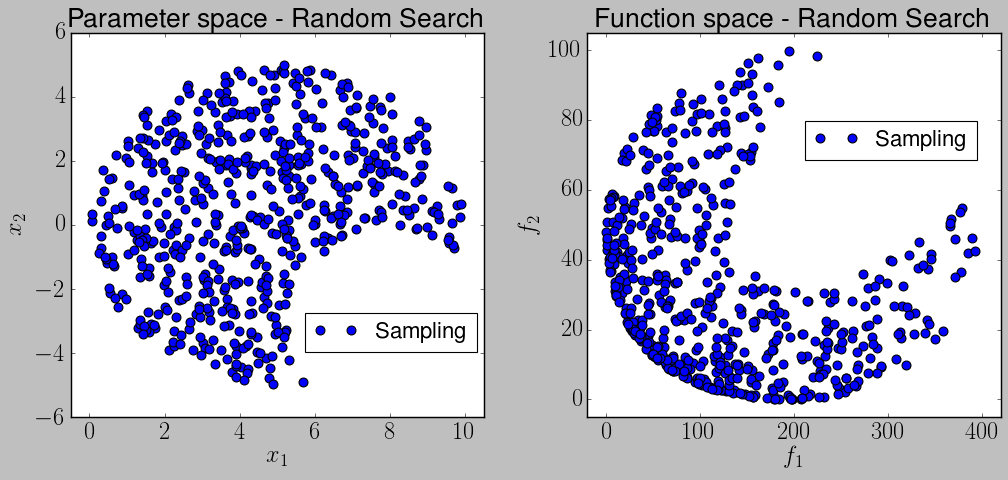

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
plt.subplots_adjust(wspace = 0.25)

N = 600

# Random search - Monte Carlo method
[RS_P,RS_funEval,RS_counter] = RS(N)
ax[0].plot(RS_P[:,0],RS_P[:,1],'bo',label='Sampling',markersize=8,markeredgewidth=1.0)
ax[0].set_xlabel(r'$x_1$', fontsize = 22)
ax[0].set_ylabel(r'$x_2$', fontsize = 22)
ax[0].tick_params(axis = 'both', labelsize = 22)
ax[0].set_title('Parameter space - Random Search', fontsize = 24)
ax[0].legend(bbox_to_anchor=(1.01,0.3), fontsize = 20)
ax[1].plot(RS_funEval[:,0],RS_funEval[:,1],'bo',label='Sampling',markersize=8,markeredgewidth=1.0)
ax[1].set_xlabel(r'$f_1$', fontsize = 22)
ax[1].set_ylabel(r'$f_2$', fontsize = 22)
ax[1].tick_params(axis = 'both', labelsize = 22)
ax[1].set_title('Function space - Random Search', fontsize = 24)
ax[1].legend(bbox_to_anchor=(0.97,0.8), fontsize = 20)

ax[0].set_xlim([-0.5,10.5])
ax[0].set_ylim([-6,6])
ax[1].set_xlim([-20,420])
ax[1].set_ylim([-5,105])

plt.savefig('./figures/mode_randomSearch.pdf', bbox_inches='tight')

In [23]:
GAE_N = 100
GAE_g = 6

# Custom genetic algorithm 
[GAE_P,GAE_funEval,GAE_counter] = GA_E(GAE_N, GAE_g, [1,0,0])

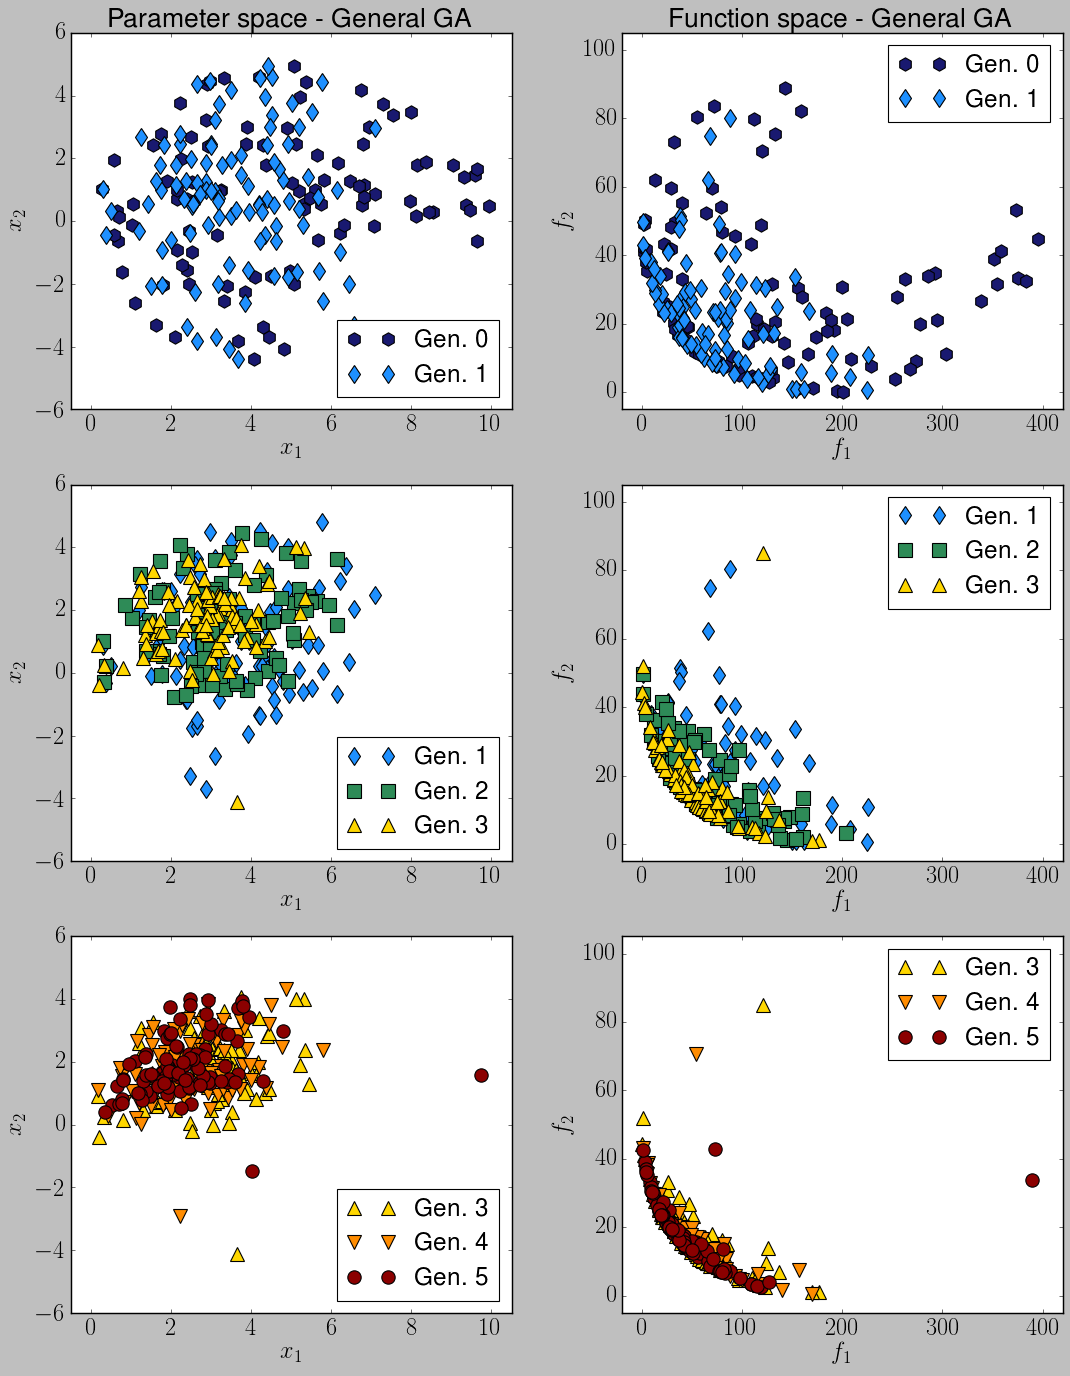

In [24]:
fig, ax = plt.subplots(3,2, figsize=(16,20))
plt.subplots_adjust(wspace = 0.25)

c = ['midnightblue','dodgerblue','seagreen','gold','darkorange','darkred']

for j in range(int(GAE_g/2)):
    if j == 0:
        ax[j][0].plot(GAE_P[j,:,0],GAE_P[j,:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j,:,0],GAE_funEval[j,:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][0].plot(GAE_P[j+1,:,0],GAE_P[j,:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+1,:,0],GAE_funEval[j+1,:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].set_title('Function space - General GA', fontsize = 24)
        ax[j][0].set_title('Parameter space - General GA', fontsize = 24)
    if j == 1:
        ax[j][0].plot(GAE_P[j,:,0],GAE_P[j,:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j,:,0],GAE_funEval[j,:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][0].plot(GAE_P[j+1,:,0],GAE_P[j+1,:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+1,:,0],GAE_funEval[j+1,:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][0].plot(GAE_P[j+2,:,0],GAE_P[j+2,:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+2,:,0],GAE_funEval[j+2,:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
    if j == 2:
        ax[j][0].plot(GAE_P[j+1,:,0],GAE_P[j+1,:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+1,:,0],GAE_funEval[j+1,:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][0].plot(GAE_P[j+2,:,0],GAE_P[j+2,:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+2,:,0],GAE_funEval[j+2,:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][0].plot(GAE_P[j+3,:,0],GAE_P[j+3,:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        ax[j][1].plot(GAE_funEval[j+3,:,0],GAE_funEval[j+3,:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        
    ax[j][0].set_xlabel(r'$x_1$', fontsize = 22)
    ax[j][0].set_ylabel(r'$x_2$', fontsize = 22)
    ax[j][0].tick_params(axis = 'both', labelsize = 22)
    ax[j][0].legend(loc = 'lower right' , fontsize = 22)
    ax[j][1].set_xlabel(r'$f_1$', fontsize = 22)
    ax[j][1].set_ylabel(r'$f_2$', fontsize = 22)
    ax[j][1].tick_params(axis = 'both', labelsize = 22)
    ax[j][1].legend(loc = 'upper right' , fontsize = 22)

    ax[j][0].set_xlim([-0.5,10.5])
    ax[j][0].set_ylim([-6,6])
    ax[j][1].set_xlim([-20,420])
    ax[j][1].set_ylim([-5,105])
    
# plt.savefig('./figures/mode_generalGAE.pdf', bbox_inches='tight')

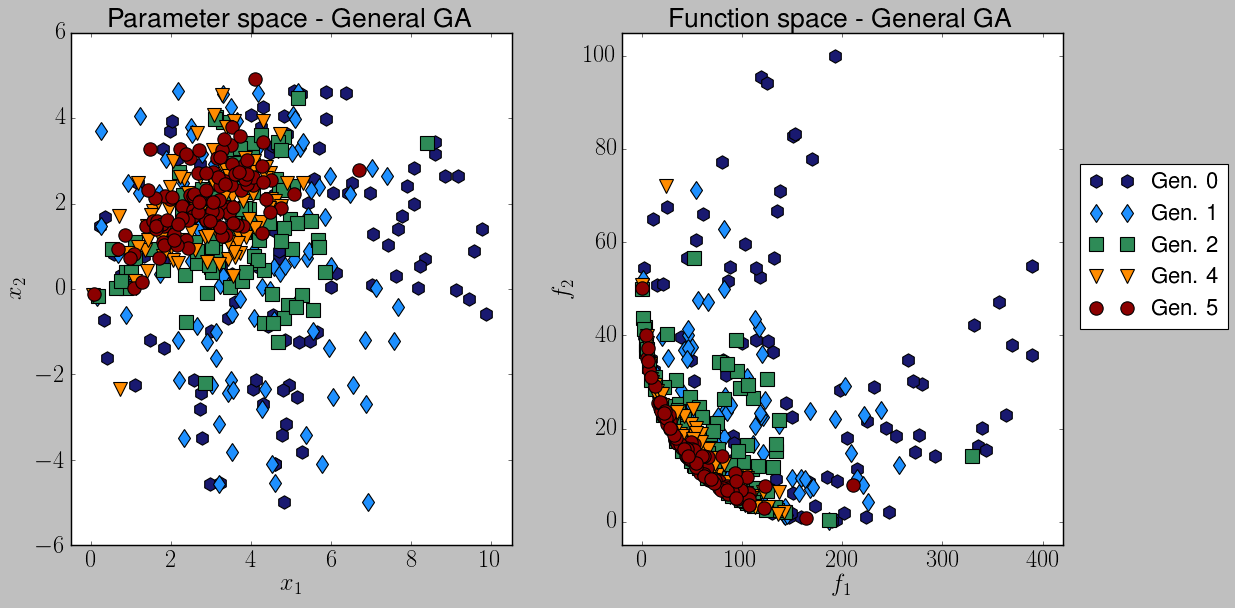

In [41]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
plt.subplots_adjust(wspace = 0.25)

c = ['midnightblue','dodgerblue','seagreen','gold','darkorange','darkred']

j = 0
ax[0].plot(GAE_P[j,:,0],GAE_P[j,:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
ax[1].plot(GAE_funEval[j,:,0],GAE_funEval[j,:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
ax[0].plot(GAE_P[j+1,:,0],GAE_P[j,:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].plot(GAE_funEval[j+1,:,0],GAE_funEval[j+1,:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].set_title('Function space - General GA', fontsize = 24)
ax[0].set_title('Parameter space - General GA', fontsize = 24)

j = 1

ax[0].plot(GAE_P[j+1,:,0],GAE_P[j+1,:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].plot(GAE_funEval[j+1,:,0],GAE_funEval[j+1,:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)

j = 2

ax[0].plot(GAE_P[j+2,:,0],GAE_P[j+2,:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
ax[1].plot(GAE_funEval[j+2,:,0],GAE_funEval[j+2,:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
ax[0].plot(GAE_P[j+3,:,0],GAE_P[j+3,:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
ax[1].plot(GAE_funEval[j+3,:,0],GAE_funEval[j+3,:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)

ax[0].set_xlabel(r'$x_1$', fontsize = 22)
ax[0].set_ylabel(r'$x_2$', fontsize = 22)
ax[0].tick_params(axis = 'both', labelsize = 22)
ax[1].legend(loc = 'lower right' , fontsize = 20, bbox_to_anchor=(1.4,0.4))
ax[1].set_xlabel(r'$f_1$', fontsize = 22)
ax[1].set_ylabel(r'$f_2$', fontsize = 22)
ax[1].tick_params(axis = 'both', labelsize = 22)
# ax[1].legend(loc = 'upper right' , fontsize = 22)

ax[0].set_xlim([-0.5,10.5])
ax[0].set_ylim([-6,6])
ax[1].set_xlim([-20,420])
ax[1].set_ylim([-5,105])
    
# plt.savefig('./figures/mode_genecralGAE.pdf', bbox_inches='tight')

In [25]:
NSGA_N = 100
NSGA_g = 6

# Custom genetic algorithm 
[NSGA_P,NSGA_funEval,NSGA_counter] = NSGA_II(NSGA_N, NSGA_g, [0,1,0])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
plt.subplots_adjust(wspace = 0.25)
c = ['midnightblue','dodgerblue','seagreen','gold','darkorange','darkred']

j=0
ax[0].plot(NSGA_P[j][:,0],NSGA_P[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
ax[1].plot(NSGA_funEval[j][:,0],NSGA_funEval[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
ax[0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].set_title('Function space - NSGA-II', fontsize = 24)
ax[0].set_title('Parameter space - NSGA-II', fontsize = 24)
j = 1
ax[0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
ax[1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
j = 2
ax[0].plot(NSGA_P[j+2][:,0],NSGA_P[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
ax[1].plot(NSGA_funEval[j+2][:,0],NSGA_funEval[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
ax[0].plot(NSGA_P[j+3][:,0],NSGA_P[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
ax[1].plot(NSGA_funEval[j+3][:,0],NSGA_funEval[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        
ax[0].set_xlabel(r'$x_1$', fontsize = 22)
ax[0].set_ylabel(r'$x_2$', fontsize = 22)
ax[0].tick_params(axis = 'both', labelsize = 22)
ax[1].legend(loc = 'lower right' , fontsize = 20, bbox_to_anchor=(1.4,0.4))
ax[1].set_xlabel(r'$f_1$', fontsize = 22)
ax[1].set_ylabel(r'$f_2$', fontsize = 22)
ax[1].tick_params(axis = 'both', labelsize = 22)
ax[0].set_xlim([-0.5,10.5])
ax[0].set_ylim([-6,6])
ax[1].set_xlim([-20,420])
ax[1].set_ylim([-5,105])
    
# plt.savefig('./figures/mode_NSGA.pdf', bbox_inches='tight')

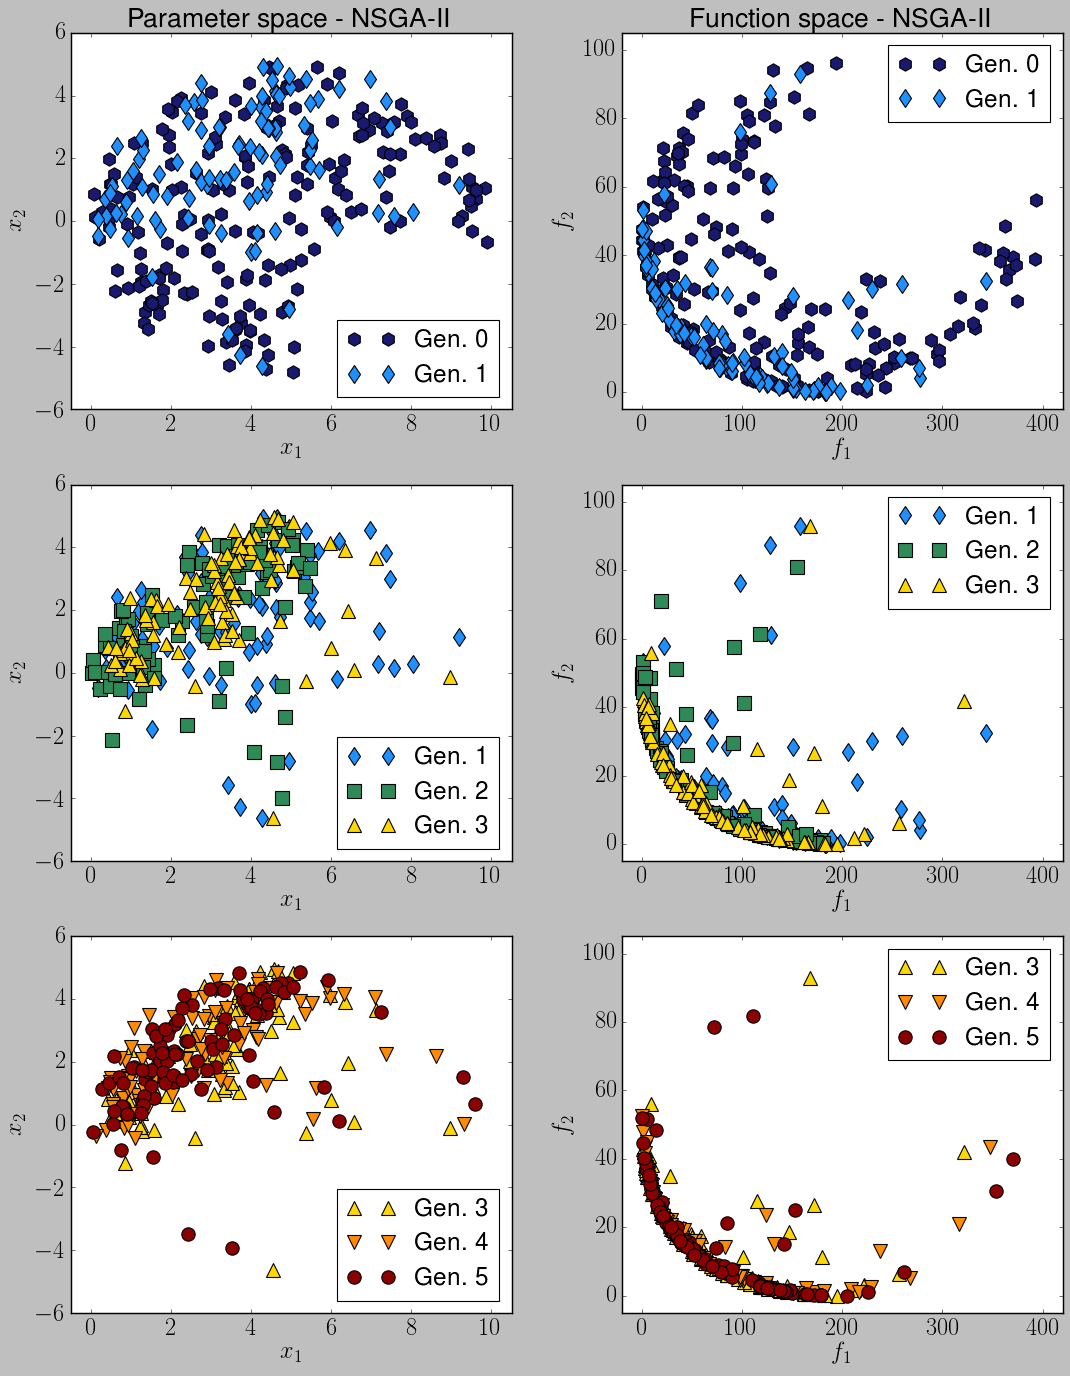

In [26]:
fig, ax = plt.subplots(3,2, figsize=(16,20))
plt.subplots_adjust(wspace = 0.25)

c = ['midnightblue','dodgerblue','seagreen','gold','darkorange','darkred']

for j in range(int(NSGA_g/2)):
    if j == 0:
        ax[j][0].plot(NSGA_P[j][:,0],NSGA_P[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j][:,0],NSGA_funEval[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].set_title('Function space - NSGA-II', fontsize = 24)
        ax[j][0].set_title('Parameter space - NSGA-II', fontsize = 24)
    if j == 1:
        ax[j][0].plot(NSGA_P[j][:,0],NSGA_P[j][:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j][:,0],NSGA_funEval[j][:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[j][0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][0].plot(NSGA_P[j+2][:,0],NSGA_P[j+2][:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+2][:,0],NSGA_funEval[j+2][:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
    if j == 2:
        ax[j][0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[j][0].plot(NSGA_P[j+2][:,0],NSGA_P[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+2][:,0],NSGA_funEval[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[j][0].plot(NSGA_P[j+3][:,0],NSGA_P[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        ax[j][1].plot(NSGA_funEval[j+3][:,0],NSGA_funEval[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        
    ax[j][0].set_xlabel(r'$x_1$', fontsize = 22)
    ax[j][0].set_ylabel(r'$x_2$', fontsize = 22)
    ax[j][0].tick_params(axis = 'both', labelsize = 22)
    ax[j][0].legend(loc = 'lower right' , fontsize = 22)
    ax[j][1].set_xlabel(r'$f_1$', fontsize = 22)
    ax[j][1].set_ylabel(r'$f_2$', fontsize = 22)
    ax[j][1].tick_params(axis = 'both', labelsize = 22)
    ax[j][1].legend(loc = 'upper right' , fontsize = 22)

    ax[j][0].set_xlim([-0.5,10.5])
    ax[j][0].set_ylim([-6,6])
    ax[j][1].set_xlim([-20,420])
    ax[j][1].set_ylim([-5,105])
    
plt.savefig('./figures/mode_NSGA.pdf', bbox_inches='tight')

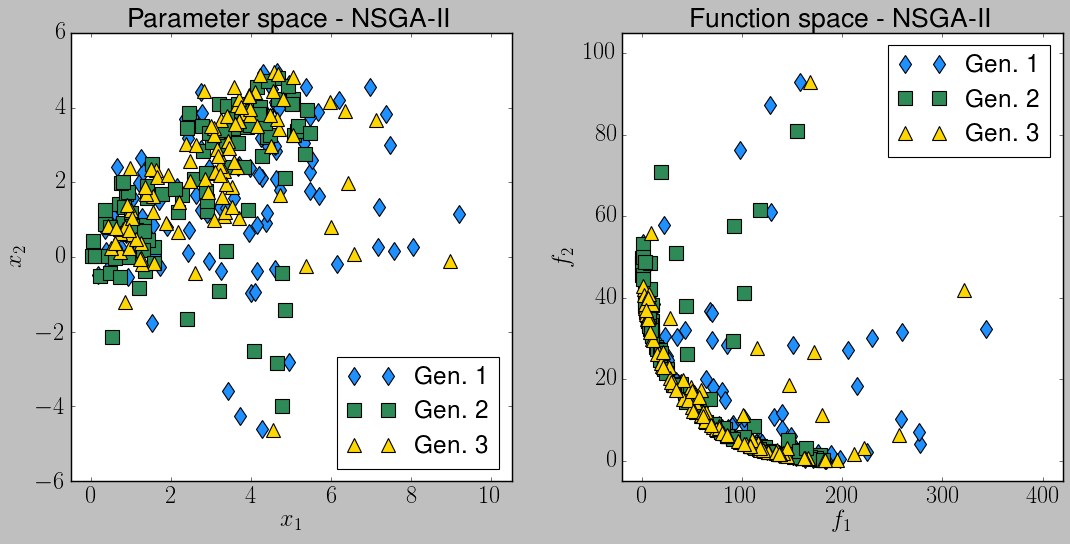

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
plt.subplots_adjust(wspace = 0.25)

c = ['midnightblue','dodgerblue','seagreen','gold','darkorange','darkred']

for j in range(1,2):
    if j == 0:
        ax[0].plot(NSGA_P[j][:,0],NSGA_P[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j][:,0],NSGA_funEval[j][:,1],'h',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'d',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
    if j == 1:
        ax[0].plot(NSGA_P[j][:,0],NSGA_P[j][:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j][:,0],NSGA_funEval[j][:,1],'d',label='Gen. %i' %(j),color=c[j],markersize=12,markeredgewidth=1)
        ax[0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'s',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[0].plot(NSGA_P[j+2][:,0],NSGA_P[j+2][:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+2][:,0],NSGA_funEval[j+2][:,1],'^',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
    if j == 2:
        ax[0].plot(NSGA_P[j+1][:,0],NSGA_P[j+1][:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+1][:,0],NSGA_funEval[j+1][:,1],'^',label='Gen. %i' %(j+1),color=c[j+1],markersize=12,markeredgewidth=1)
        ax[0].plot(NSGA_P[j+2][:,0],NSGA_P[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+2][:,0],NSGA_funEval[j+2][:,1],'v',label='Gen. %i' %(j+2),color=c[j+2],markersize=12,markeredgewidth=1)
        ax[0].plot(NSGA_P[j+3][:,0],NSGA_P[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        ax[1].plot(NSGA_funEval[j+3][:,0],NSGA_funEval[j+3][:,1],'o',label='Gen. %i' %(j+3),color=c[j+3],markersize=12,markeredgewidth=1)
        
    ax[1].set_title('Function space - NSGA-II', fontsize = 24)
    ax[0].set_title('Parameter space - NSGA-II', fontsize = 24)    
    ax[0].set_xlabel(r'$x_1$', fontsize = 22)
    ax[0].set_ylabel(r'$x_2$', fontsize = 22)
    ax[0].tick_params(axis = 'both', labelsize = 22)
    ax[0].legend(loc = 'lower right' , fontsize = 22)
    ax[1].set_xlabel(r'$f_1$', fontsize = 22)
    ax[1].set_ylabel(r'$f_2$', fontsize = 22)
    ax[1].tick_params(axis = 'both', labelsize = 22)
    ax[1].legend(loc = 'upper right' , fontsize = 22)
    ax[0].set_xlim([-0.5,10.5])
    ax[0].set_ylim([-6,6])
    ax[1].set_xlim([-20,420])
    ax[1].set_ylim([-5,105])
    
plt.savefig('./figures/NSGA2.pdf', bbox_inches='tight')

### 2.5 Methods comparison
In order to compare NSGA-II with a general genetic algorithm and with random search (and due to the stochasticity of the methods) running the same simulation a number of times will give a nice overview on how the results vary from one method to another.

1000.0 1000.0 1000.0


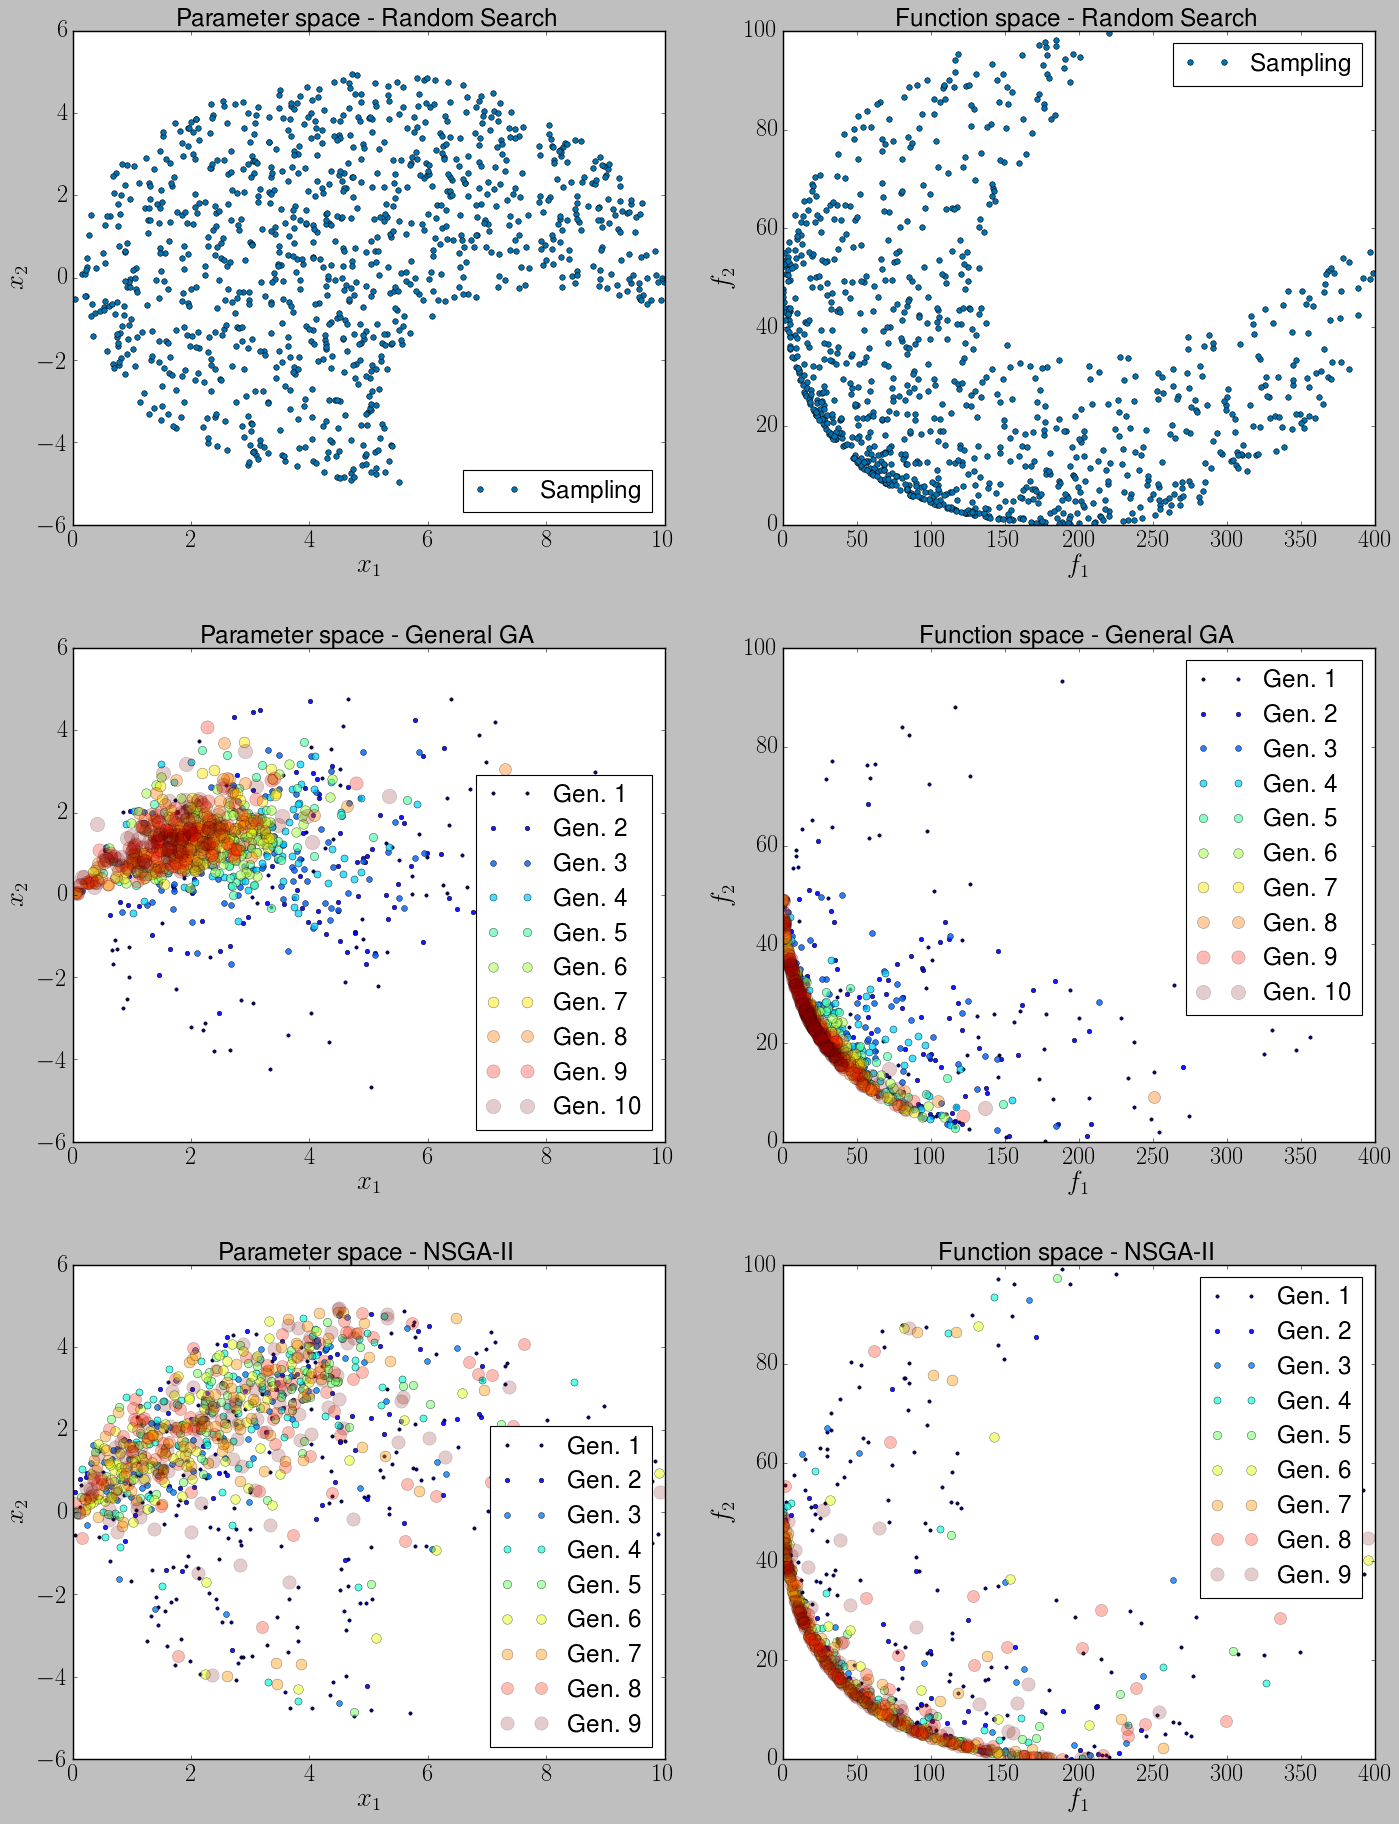

In [28]:
fig, ax = plt.subplots(3,2, figsize=(21,27))
plt.subplots_adjust(hspace = 0.25)

N = 1000
GAE_N = 100
GAE_g = 10
NSGA_N = 100
NSGA_g = 9

# Random search - Monte Carlo method
[RS_P,RS_funEval,RS_counter] = RS(N)
ax[0][0].plot(RS_P[:,0],RS_P[:,1],'o',label='Sampling',markersize=5)
ax[0][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[0][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[0][0].tick_params(axis = 'both', labelsize = 22)
ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][0].legend(loc = 'lower right' , fontsize = 22)
ax[0][1].plot(RS_funEval[:,0],RS_funEval[:,1],'o',label='Sampling',markersize=5)
ax[0][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[0][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[0][1].tick_params(axis = 'both', labelsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[0][1].legend(loc = 'upper right' , fontsize = 22)


# Custom genetic algorithm 
[GAE_P,GAE_funEval,GAE_counter] = GA_E(GAE_N, GAE_g, [0,1,0])

ms = np.linspace(3,len(GAE_P)+3,len(GAE_P))
al = np.linspace(1,0.2,len(GAE_P))
c = cm.jet(np.linspace(0,1,len(GAE_P)))

for i in range(len(GAE_P)):
    ax[1][0].plot(GAE_P[i,:,0],GAE_P[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
    ax[1][1].plot(GAE_funEval[i,:,0],GAE_funEval[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[1][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[1][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[1][0].tick_params(axis = 'both', labelsize = 22)
ax[1][0].set_title('Parameter space - General GA', fontsize = 22)
ax[1][0].legend(loc = 'lower right' , fontsize = 22)
ax[1][0].set_xlim(ax[0][0].get_xlim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[1][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[1][1].tick_params(axis = 'both', labelsize = 22)
ax[1][1].set_title('Function space - General GA', fontsize = 22)
ax[1][1].legend(loc = 'upper right' , fontsize = 22)
ax[1][1].set_xlim(ax[0][1].get_xlim())
ax[1][1].set_ylim(ax[0][1].get_ylim())

# NSGA-II algorithm
[NSGA_P,NSGA_funEval,NSGA_counter] = NSGA_II(NSGA_N, NSGA_g,[0,1,0])

ms = np.linspace(3,len(NSGA_P)+3,len(NSGA_P))
al = np.linspace(1,0.2,len(NSGA_P))
c = cm.jet(np.linspace(0,1,len(NSGA_P)))

for i in range(len(NSGA_P)):
    ax[2][0].plot(NSGA_P[i][:,0],NSGA_P[i][:,1],'o',label='Gen. %i' %(i+1), color=c[i],alpha=al[i],markersize=ms[i])
    ax[2][1].plot(NSGA_funEval[i][:,0],NSGA_funEval[i][:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[2][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[2][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[2][0].tick_params(axis = 'both', labelsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][0].set_xlim(ax[0][0].get_xlim())
ax[2][0].set_ylim(ax[0][0].get_ylim())
ax[2][0].legend(loc = 'lower right' , fontsize = 22)
ax[2][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[2][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[2][1].tick_params(axis = 'both', labelsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
ax[2][1].legend(loc = 'upper right' , fontsize = 22)
ax[2][1].set_xlim(ax[0][1].get_xlim())
ax[2][1].set_ylim(ax[0][1].get_ylim())

plt.savefig('./figures/random_BK%i.pdf' %N,bbox_inches='tight')

print(RS_counter, GAE_counter, NSGA_counter)

/home/jlobatop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/home/jlobatop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in less
/home/jlobatop/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in less


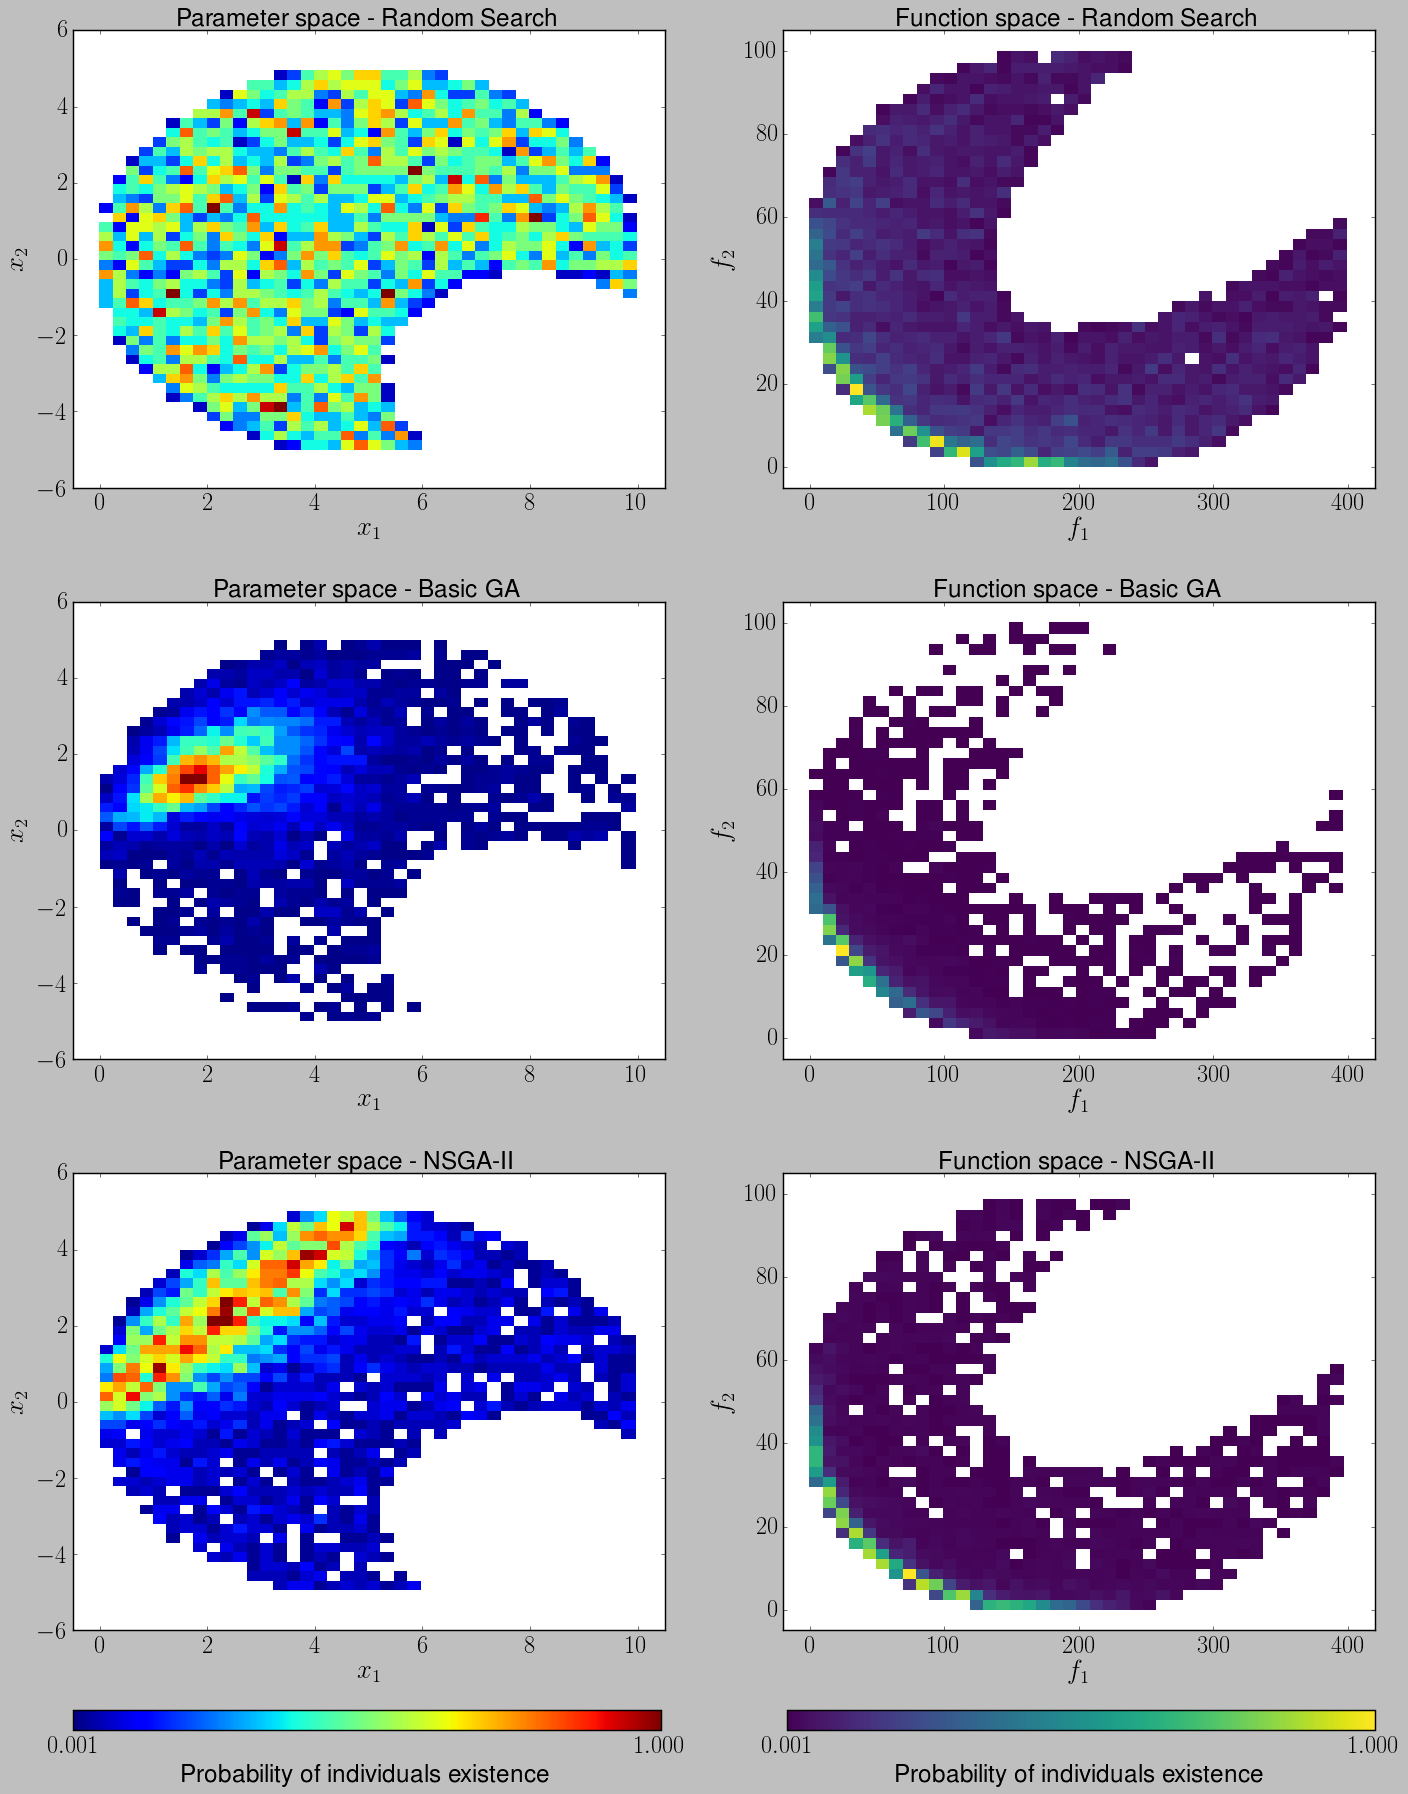

In [29]:
RSfe = []
RSp = []
GAEfe = []
GAEp = []
NSGAfe = []
NSGAp = []

RS_N = [80,90,100,110,200,225,250,275,450,500,550,600,900,1000,1100,1200]
GAE_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
GAE_g = [8,9,10,11,8,9,10,11,9,10,11,12,9,10,11,12]
NSGA_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
NSGA_g = [7,8,9,10,7,8,9,10,8,9,10,11,8,9,10,11]

for i in range(len(RS_N)):
    [RS_P,RS_funEval,_] = RS(RS_N[i])
    RSfe.append(RS_funEval)
    RSp.append(RS_P)
    
    [GAE_P,GAE_funEval,_] = GA_E(GAE_N[i], GAE_g[i],[1,0,0])
    GAEfe.append(np.reshape(GAE_funEval[:,:,:],[GAE_funEval[:,:,:].shape[0]*GAE_funEval[:,:,:].shape[1],GAE_funEval[:,:,:].shape[2]]))
    GAEp.append(np.reshape(GAE_P[:,:,:],[GAE_P[:,:,:].shape[0]*GAE_P[:,:,:].shape[1],GAE_P[:,:,:].shape[2]]))
   
    [NSGA_P,NSGA_funEval,_] = NSGA_II(NSGA_N[i], NSGA_g[i], [1,0,0])
    NSGAfe.append(np.vstack(NSGA_funEval))
    NSGAp.append(np.vstack(NSGA_P))
    
freqFECM = cm.viridis
freqFECM.set_under('w')
freqPCM = cm.jet
freqPCM.set_under('w')

binNo = 40

fig, ax = plt.subplots(3,2, figsize=(21,25))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[2][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.05, 0.35, 0.01])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', labelsize = 22)
cbar.set_label('Probability of individuals existence', fontsize=22)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[2][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.05, 0.35, 0.01])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', labelsize = 22)
ccbar.set_label('Probability of individuals existence', fontsize=22)

for i in range(3):
    ax[i][0].set_xlim([-0.5,10.5]);
    ax[i][0].set_ylim([-6,6]);
    ax[i][1].set_xlim([-20,420]);
    ax[i][1].set_ylim([-5,105]);

    ax[i][0].set_xlabel(r'$x_1$', fontsize = 24)
    ax[i][0].set_ylabel(r'$x_2$', fontsize = 24)
    ax[i][1].set_xlabel(r'$f_1$', fontsize = 24)
    ax[i][1].set_ylabel(r'$f_2$', fontsize = 24)
    ax[i][0].tick_params(axis = 'both', labelsize = 22)
    ax[i][1].tick_params(axis = 'both', labelsize = 22)

ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[1][0].set_title('Parameter space - Basic GA', fontsize = 22)
ax[1][1].set_title('Function space - Basic GA', fontsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
    
plt.savefig('./figures/hist_BK.pdf', bbox_inches='tight')

In [110]:
RSfe = []
RSp = []
GAEfe = []
GAEp = []
NSGAfe = []
NSGAp = []

RS_N = [80,90,100,110,200,225,250,275,450,500,550,600,900,1000,1100,1200]
GAE_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
GAE_g = [8,9,10,11,8,9,10,11,9,10,11,12,9,10,11,12]
NSGA_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
NSGA_g = [7,8,9,10,7,8,9,10,8,9,10,11,8,9,10,11]

for i in range(len(RS_N)):
    [RS_P,RS_funEval,_] = RS(RS_N[i])
    RSfe.append(RS_funEval)
    RSp.append(RS_P)
    
    [GAE_P,GAE_funEval,_] = GA_E(GAE_N[i], GAE_g[i],[1,0,0])
    GAEfe.append(np.reshape(GAE_funEval[:,:,:],[GAE_funEval[:,:,:].shape[0]*GAE_funEval[:,:,:].shape[1],GAE_funEval[:,:,:].shape[2]]))
    GAEp.append(np.reshape(GAE_P[:,:,:],[GAE_P[:,:,:].shape[0]*GAE_P[:,:,:].shape[1],GAE_P[:,:,:].shape[2]]))
   
    [NSGA_P,NSGA_funEval,_] = NSGA_II(NSGA_N[i], NSGA_g[i], [1,0,0])
    NSGAfe.append(np.vstack(NSGA_funEval))
    NSGAp.append(np.vstack(NSGA_P))
    
freqFECM = cm.viridis
freqFECM.set_under('w')
freqPCM = cm.jet
freqPCM.set_under('w')

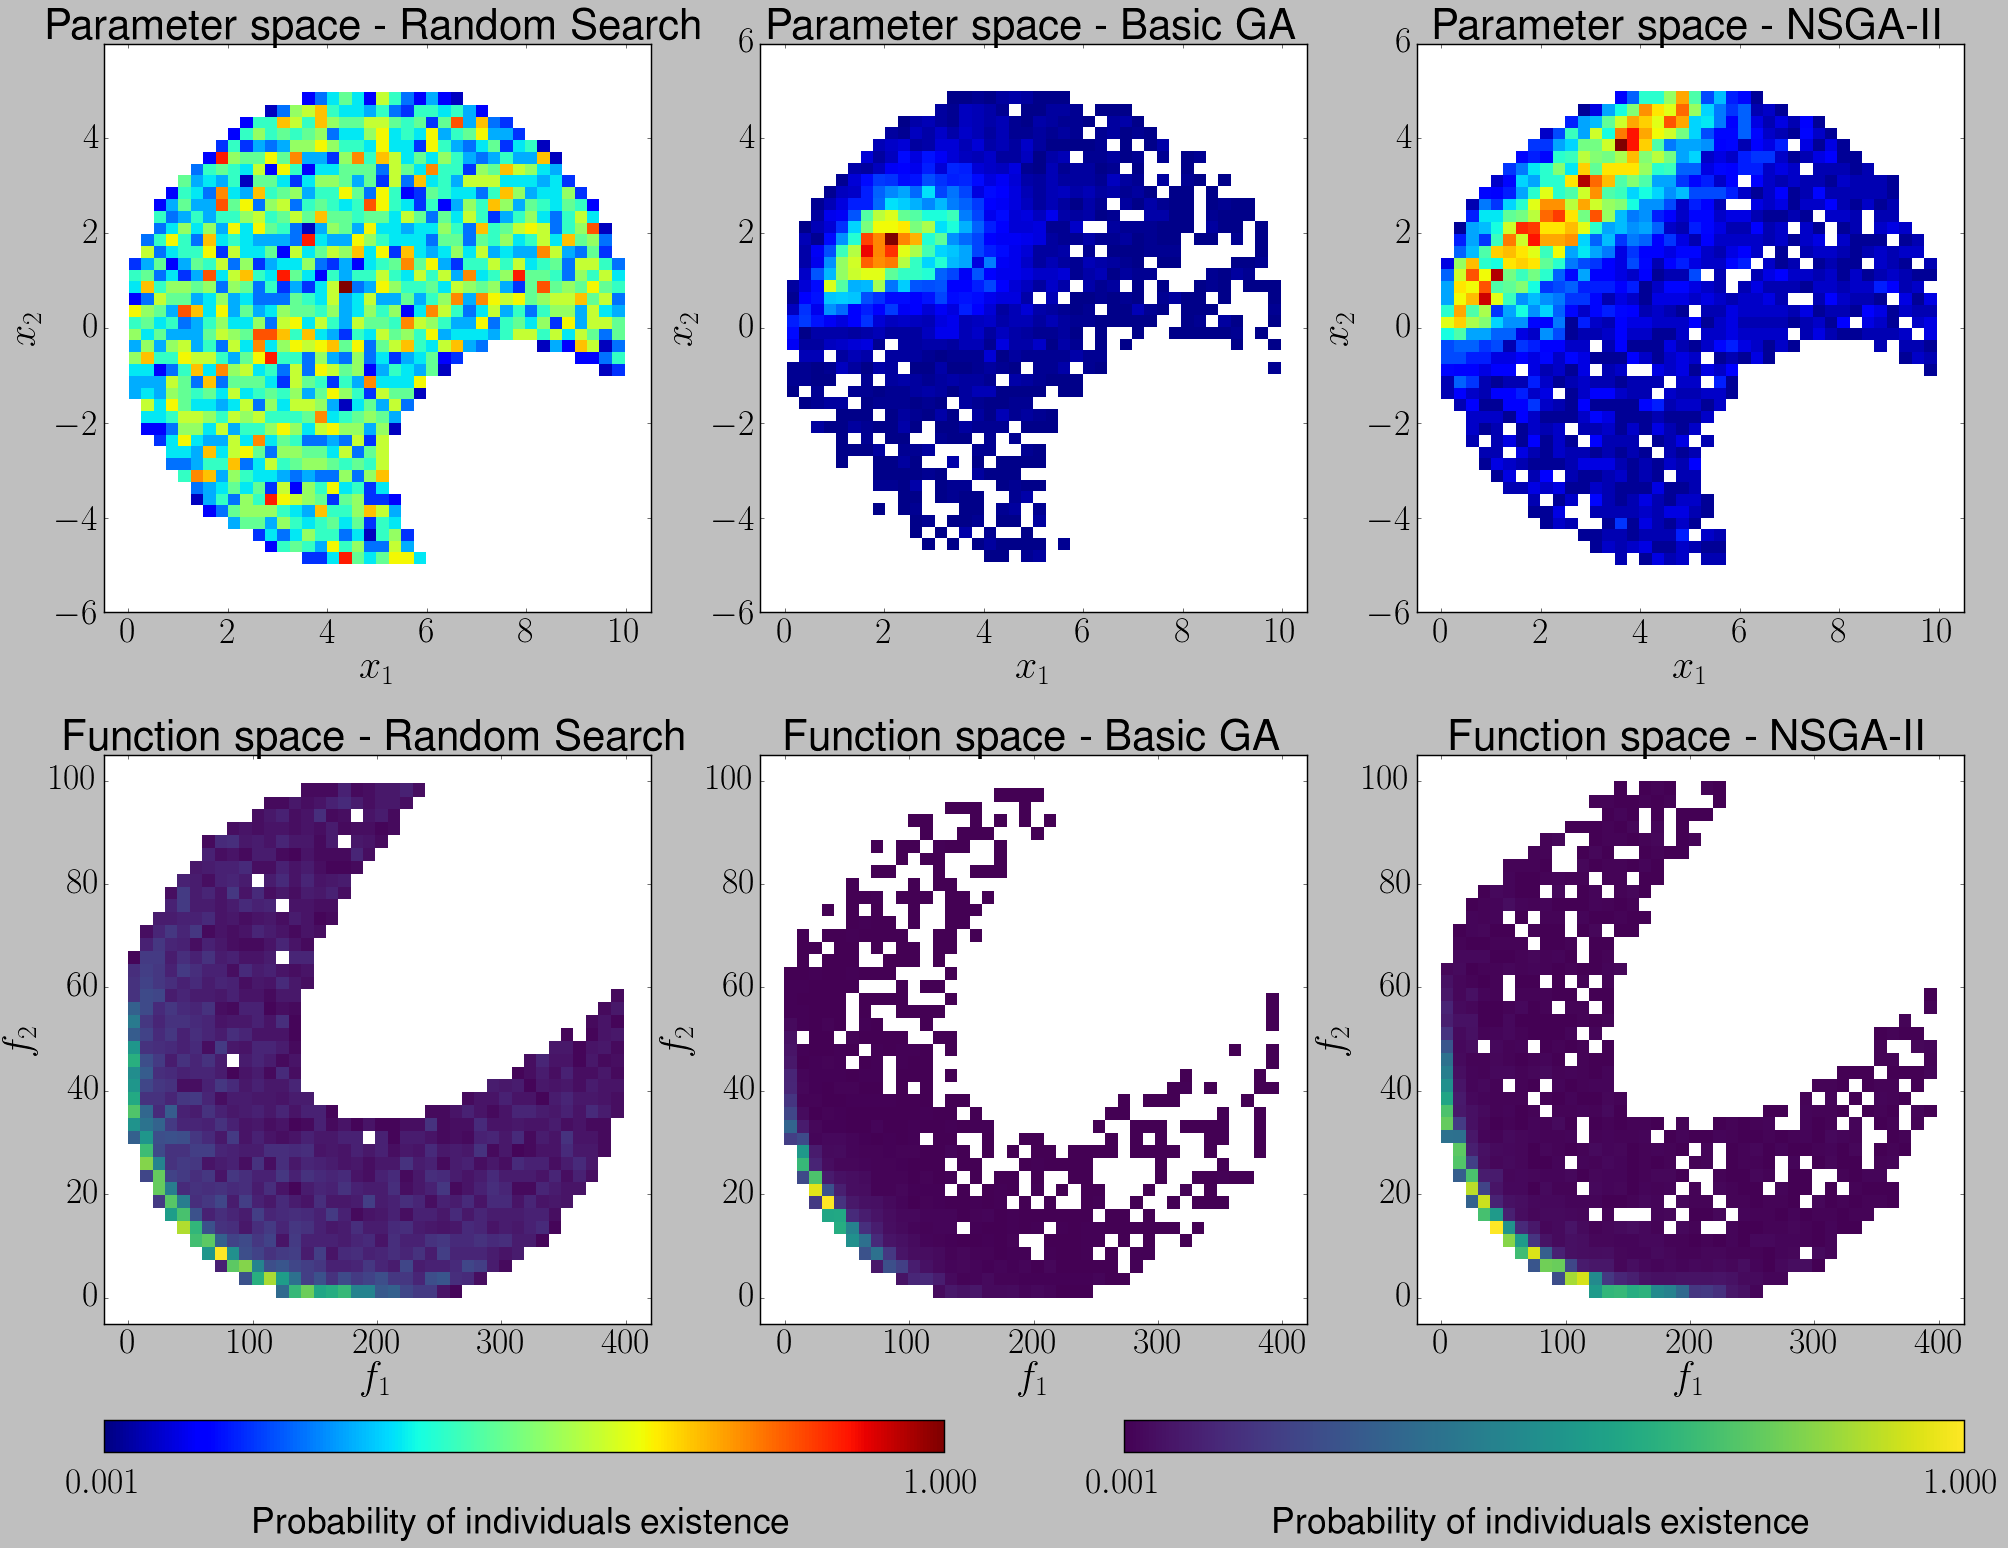

In [123]:
binNo = 40

fig, ax = plt.subplots(2,3, figsize=(30,20))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[0][2].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.02, 0.35, 0.02])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', pad = 15, labelsize = 32)
cbar.set_label('Probability of individuals existence', fontsize=32)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[1][2].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.02, 0.35, 0.02])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', pad = 15,labelsize = 32)
ccbar.set_label('Probability of individuals existence', fontsize=32)

for i in range(3):
    ax[0][i].set_xlim([-0.5,10.5]);
    ax[0][i].set_ylim([-6,6]);
    ax[1][i].set_xlim([-20,420]);
    ax[1][i].set_ylim([-5,105]);

    ax[0][i].set_xlabel(r'$x_1$', fontsize = 36)
    ax[0][i].set_ylabel(r'$x_2$', fontsize = 36)
    ax[1][i].set_xlabel(r'$f_1$', fontsize = 36)
    ax[1][i].set_ylabel(r'$f_2$', fontsize = 36)
    ax[0][i].tick_params(axis = 'both', labelsize = 32)
    ax[1][i].tick_params(axis = 'both', labelsize = 32)

labels = [item.get_text() for item in ax[0][0].get_yticklabels()]
labels = ['$-6$','$-4$','$-2$','$0$','$2$','$4$','']
ax[0][0].set_yticklabels(labels)
    
ax[0][0].set_title('Parameter space - Random Search', fontsize = 38)
ax[1][0].set_title('Function space - Random Search', fontsize = 38)
ax[0][1].set_title('Parameter space - Basic GA', fontsize = 38)
ax[1][1].set_title('Function space - Basic GA', fontsize = 38)
ax[0][2].set_title('Parameter space - NSGA-II', fontsize = 38)
ax[1][2].set_title('Function space - NSGA-II', fontsize = 38)
    
plt.savefig('./figures/BK.pdf', bbox_inches='tight')

### 2.6 Metrics analysis (generation & individuals)

In order to draw some conclusion about what will be better (having more individuals with less generations or less indiviudals but more generations), some metrics will be used. Then, some tests will be made in order too get the better parameters for the different cases. It can be seen that the test have been carried out with $2^n$ individuals per generation, given that simulations will be done in parallel when possible, using an even number of processors. NUmber will be kept low to avoid too high computational times.

In [27]:
def dist(a,b):
    if len(a.shape) == 1 and len(b.shape) == 1:
        return np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
    elif len(a.shape) == 1:
        return np.sqrt((a[0]-b[:,0])**2+(a[1]-b[:,1])**2)
    elif len(b.shape) == 1:
        return np.sqrt((a[:,0]-b[0])**2+(a[:,1]-b[1])**2)
    else:
        return np.sqrt((a[:,0]-b[:,0])**2+(a[:,1]-b[:,1])**2)

In [28]:
def conv_metric(pareto, truePareto):
    mindst = np.zeros((len(pareto)))
    for i in range(len(pareto)):
        mindst[i] = np.min(dist(truePareto[:],pareto[i,:]))
    return mindst.mean(), mindst.std()

In [29]:
def diver_metric(pareto, truePareto):
    extTPx = truePareto[np.argmax(truePareto[:,0]),:]
    extTPy = truePareto[np.argmax(truePareto[:,1]),:]
    d_i = np.zeros((len(pareto)-1))
    for i in range(len(d_i)):
        d_i[i] = dist(pareto[np.argsort(pareto[:,0]),:][i+1,:],
                      pareto[np.argsort(pareto[:,0]),:][i,:])
    df = dist(pareto[np.argmax(pareto[:,1]),:],extTPy)
    dl = dist(pareto[np.argmax(pareto[:,0]),:],extTPx)
    delta = (df+dl+np.sum(np.abs(d_i-d_i.mean())))/(df+dl+(len(d_i))*d_i.mean())
    return delta

## 3. Poloni's function

### 3.1 Functions

In [146]:
funNo = 2

def fun(x,y,no):
    """Objective function evaluation 
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the function that wants to be evaluated
    (although not an input, this function should be used with a defined funNo)

    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This will return the 'no' functions evaluated in x and y with the number of times 
    that the function has been called (this will be translated in CFD evaluations). 
    This follows Python notation where the first function is 0, the second is 1,...
    """
    
    # Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    
    # Conditional case for each one of the functions
    if no == 0:
        A1 = 0.5*np.sin(1)-2*np.cos(1)+np.sin(2)-1.5*np.cos(2)
        A2 = 1.5*np.sin(1)-np.cos(1)+2*np.sin(2)-0.5*np.cos(2)
        B1 = 0.5*np.sin(x)-2*np.cos(x)+np.sin(y)-1.5*np.cos(y)
        B2 = 1.5*np.sin(x)-np.cos(x)+2*np.sin(y)-0.5*np.cos(y)
        return 1+(A1-B1)**2+(A2-B2)**2
    if no == 1:
        return (x+3)**2+(y+1)**2

### 3.2 Domain

In [147]:
x_low = -np.pi
x_high = np.pi
y_low = -np.pi
y_high = np.pi

### 3.3 Constrains

In [148]:
def const(x,y,no):
    """Parameter space constraints for x and y values
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the constraint that wants to be evaluated
    (although not an input, this function should be used with constVal and
    compMode lists that have the constraints values)
    
    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This function evaluates the constraints for the set of values in x and y in the
    desired function no-th. This follows Python notation where the first function is
    0, the second is 1,...
    """
    
    # Conditional for domain
    if no == 0:
        return x
    if no == 1:
        return x
    if no == 2:
        return y
    if no == 3:
        return y

In [149]:
constVal = [x_high, x_low, y_high, y_low]
compMode = ['leq', 'geq', 'leq', 'geq']

In [150]:
def constrainedPts(points, const, constVal, compMode):
    """Function that will constraint points out of bounds
    
    INPUTS:
    points:     points in the parameter search space as a numpy.ndarray
    const:      function with search space components and constraints number
    constVal:   comparison value for each constraint as list
    compMode:   comparison mode ('leq','geq','less','greater','equal') as list
    
    OUTPUTS:
    booleanMat: boolean matrix with 1 for the non valid points (constrained)
    
    This function will evaluate the constraints for all points in the set returning a 
    boolean masked matrix with the values that are constrained. It will raise an error
    in there is something wrong with the comparison mode. 
    """
    
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i],
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], 
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

### 3.4 Methods comparison

1000.0 1000.0


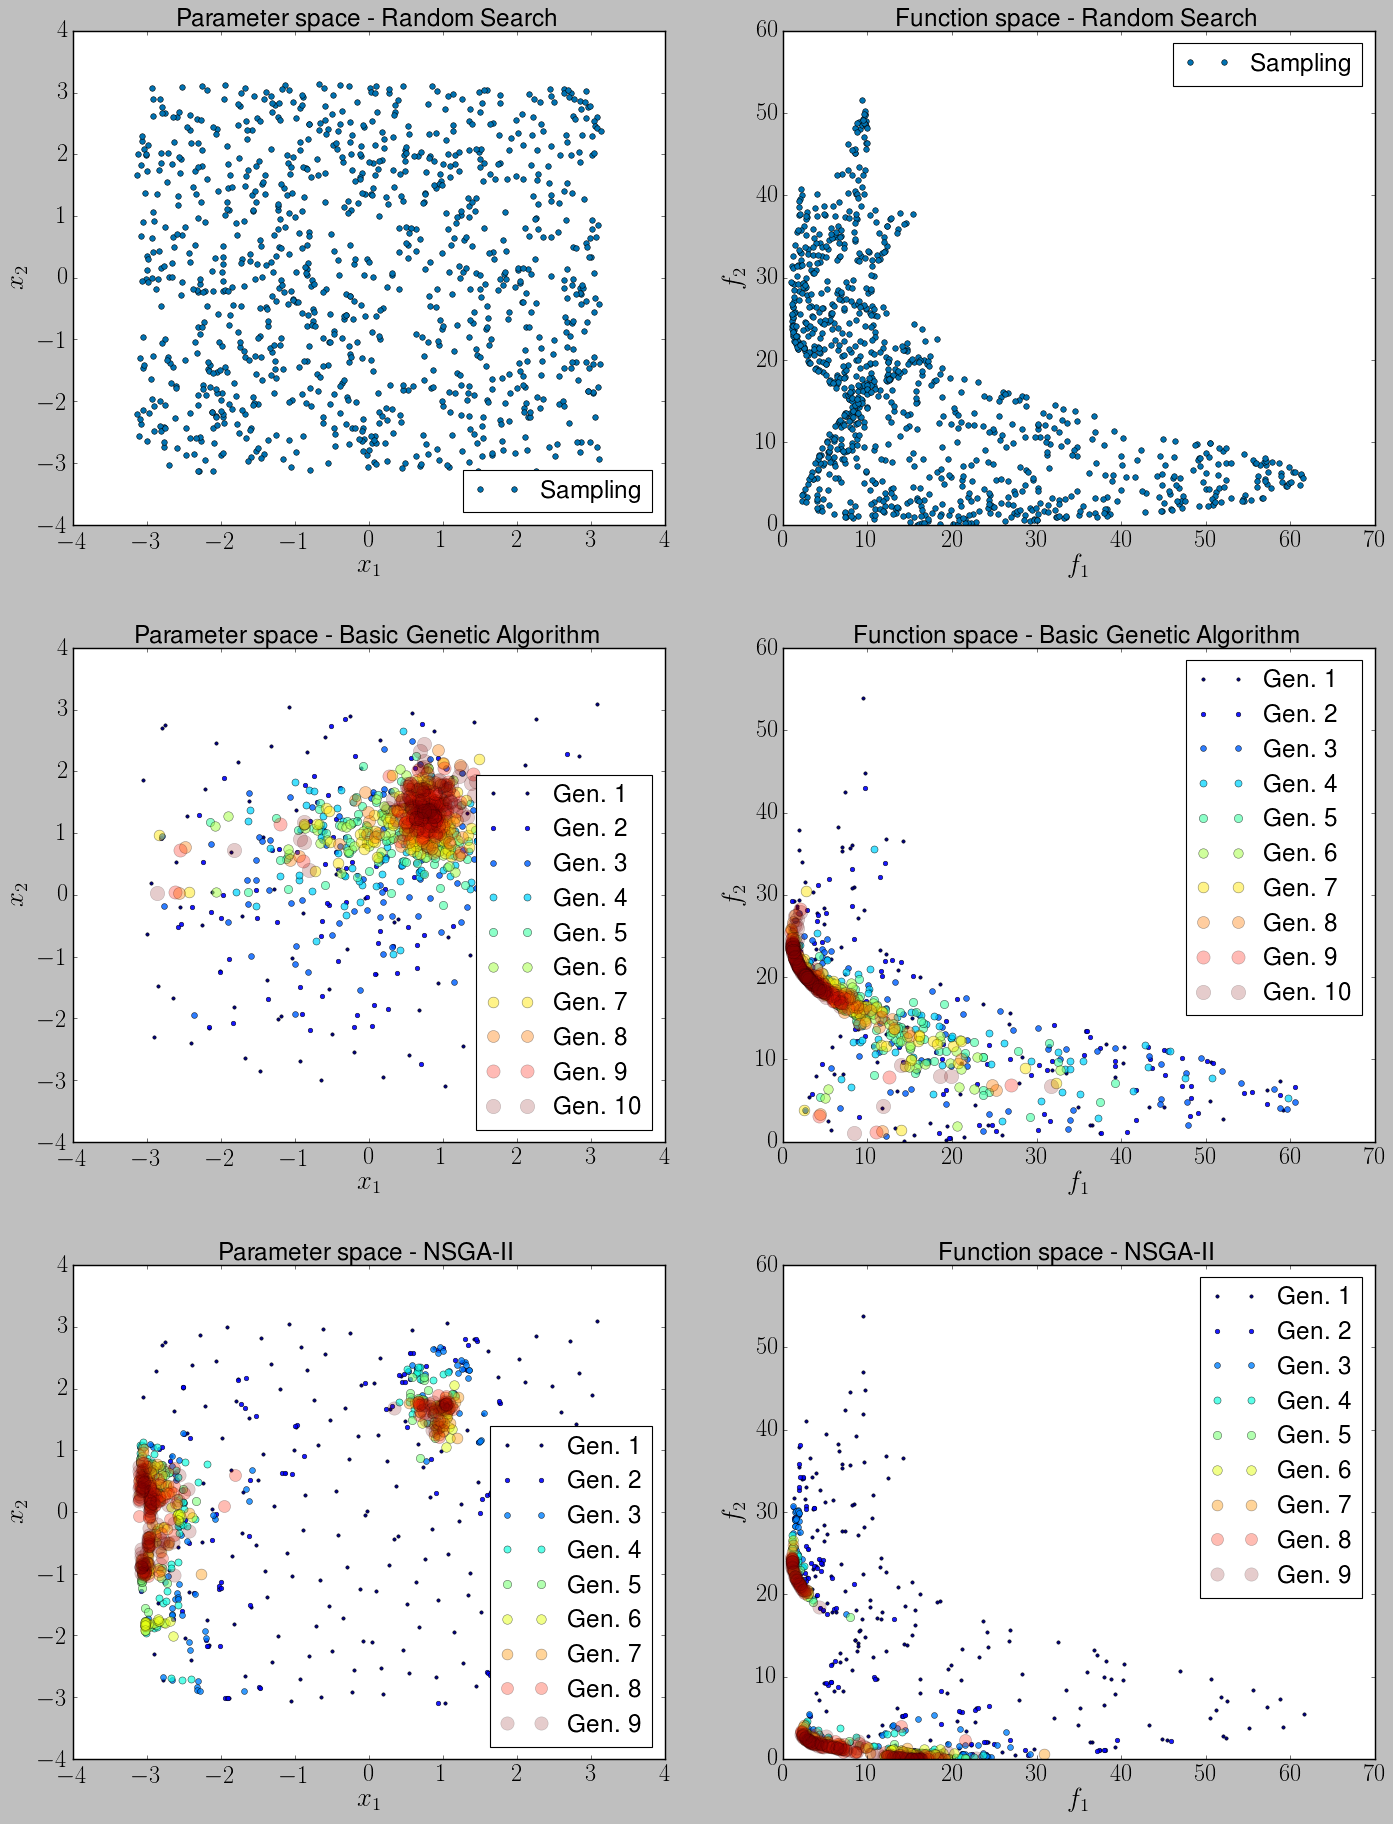

In [82]:
fig, ax = plt.subplots(3,2, figsize=(21,27))
plt.subplots_adjust(hspace = 0.25)

N = 1000
GAE_N = 100
GAE_g = 10
NSGA_N = 100
NSGA_g = 9

# Random search - Monte Carlo method
[RS_P,RS_funEval,RS_counter] = RS(N)
ax[0][0].plot(RS_P[:,0],RS_P[:,1],'o',label='Sampling',markersize=5)
ax[0][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[0][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[0][0].tick_params(axis = 'both', labelsize = 22)
ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][0].legend(loc = 'lower right' , fontsize = 22)
ax[0][1].plot(RS_funEval[:,0],RS_funEval[:,1],'o',label='Sampling',markersize=5)
ax[0][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[0][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[0][1].tick_params(axis = 'both', labelsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[0][1].legend(loc = 'upper right' , fontsize = 22)


# Custom genetic algorithm 
[GAE_P,GAE_funEval,GAE_counter] = GA_E(GAE_N, GAE_g, [0,1,0])

ms = np.linspace(3,len(GAE_P)+3,len(GAE_P))
al = np.linspace(1,0.2,len(GAE_P))
c = cm.jet(np.linspace(0,1,len(GAE_P)))

for i in range(len(GAE_P)):
    ax[1][0].plot(GAE_P[i,:,0],GAE_P[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
    ax[1][1].plot(GAE_funEval[i,:,0],GAE_funEval[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[1][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[1][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[1][0].tick_params(axis = 'both', labelsize = 22)
ax[1][0].set_title('Parameter space - Basic Genetic Algorithm', fontsize = 22)
ax[1][0].legend(loc = 'lower right' , fontsize = 22)
ax[1][0].set_xlim(ax[0][0].get_xlim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[1][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[1][1].tick_params(axis = 'both', labelsize = 22)
ax[1][1].set_title('Function space - Basic Genetic Algorithm', fontsize = 22)
ax[1][1].legend(loc = 'upper right' , fontsize = 22)
ax[1][1].set_xlim(ax[0][1].get_xlim())
ax[1][1].set_ylim(ax[0][1].get_ylim())

# NSGA-II algorithm
[NSGA_P,NSGA_funEval,NSGA_counter] = NSGA_II(NSGA_N, NSGA_g, [0,1,0])

ms = np.linspace(3,len(NSGA_P)+3,len(NSGA_P))
al = np.linspace(1,0.2,len(NSGA_P))
c = cm.jet(np.linspace(0,1,len(NSGA_P)))

for i in range(len(NSGA_P)):
    ax[2][0].plot(NSGA_P[i][:,0],NSGA_P[i][:,1],'o',label='Gen. %i' %(i+1), color=c[i],alpha=al[i],markersize=ms[i])
    ax[2][1].plot(NSGA_funEval[i][:,0],NSGA_funEval[i][:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[2][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[2][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[2][0].tick_params(axis = 'both', labelsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][0].set_xlim(ax[0][0].get_xlim())
ax[2][0].set_ylim(ax[0][0].get_ylim())
ax[2][0].legend(loc = 'lower right' , fontsize = 22)
ax[2][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[2][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[2][1].tick_params(axis = 'both', labelsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
ax[2][1].legend(loc = 'upper right' , fontsize = 22)
ax[2][1].set_xlim(ax[0][1].get_xlim())
ax[2][1].set_ylim(ax[0][1].get_ylim())

plt.savefig('./figures/random_POL%i.pdf' %N,bbox_inches='tight')

print(GAE_counter, NSGA_counter)

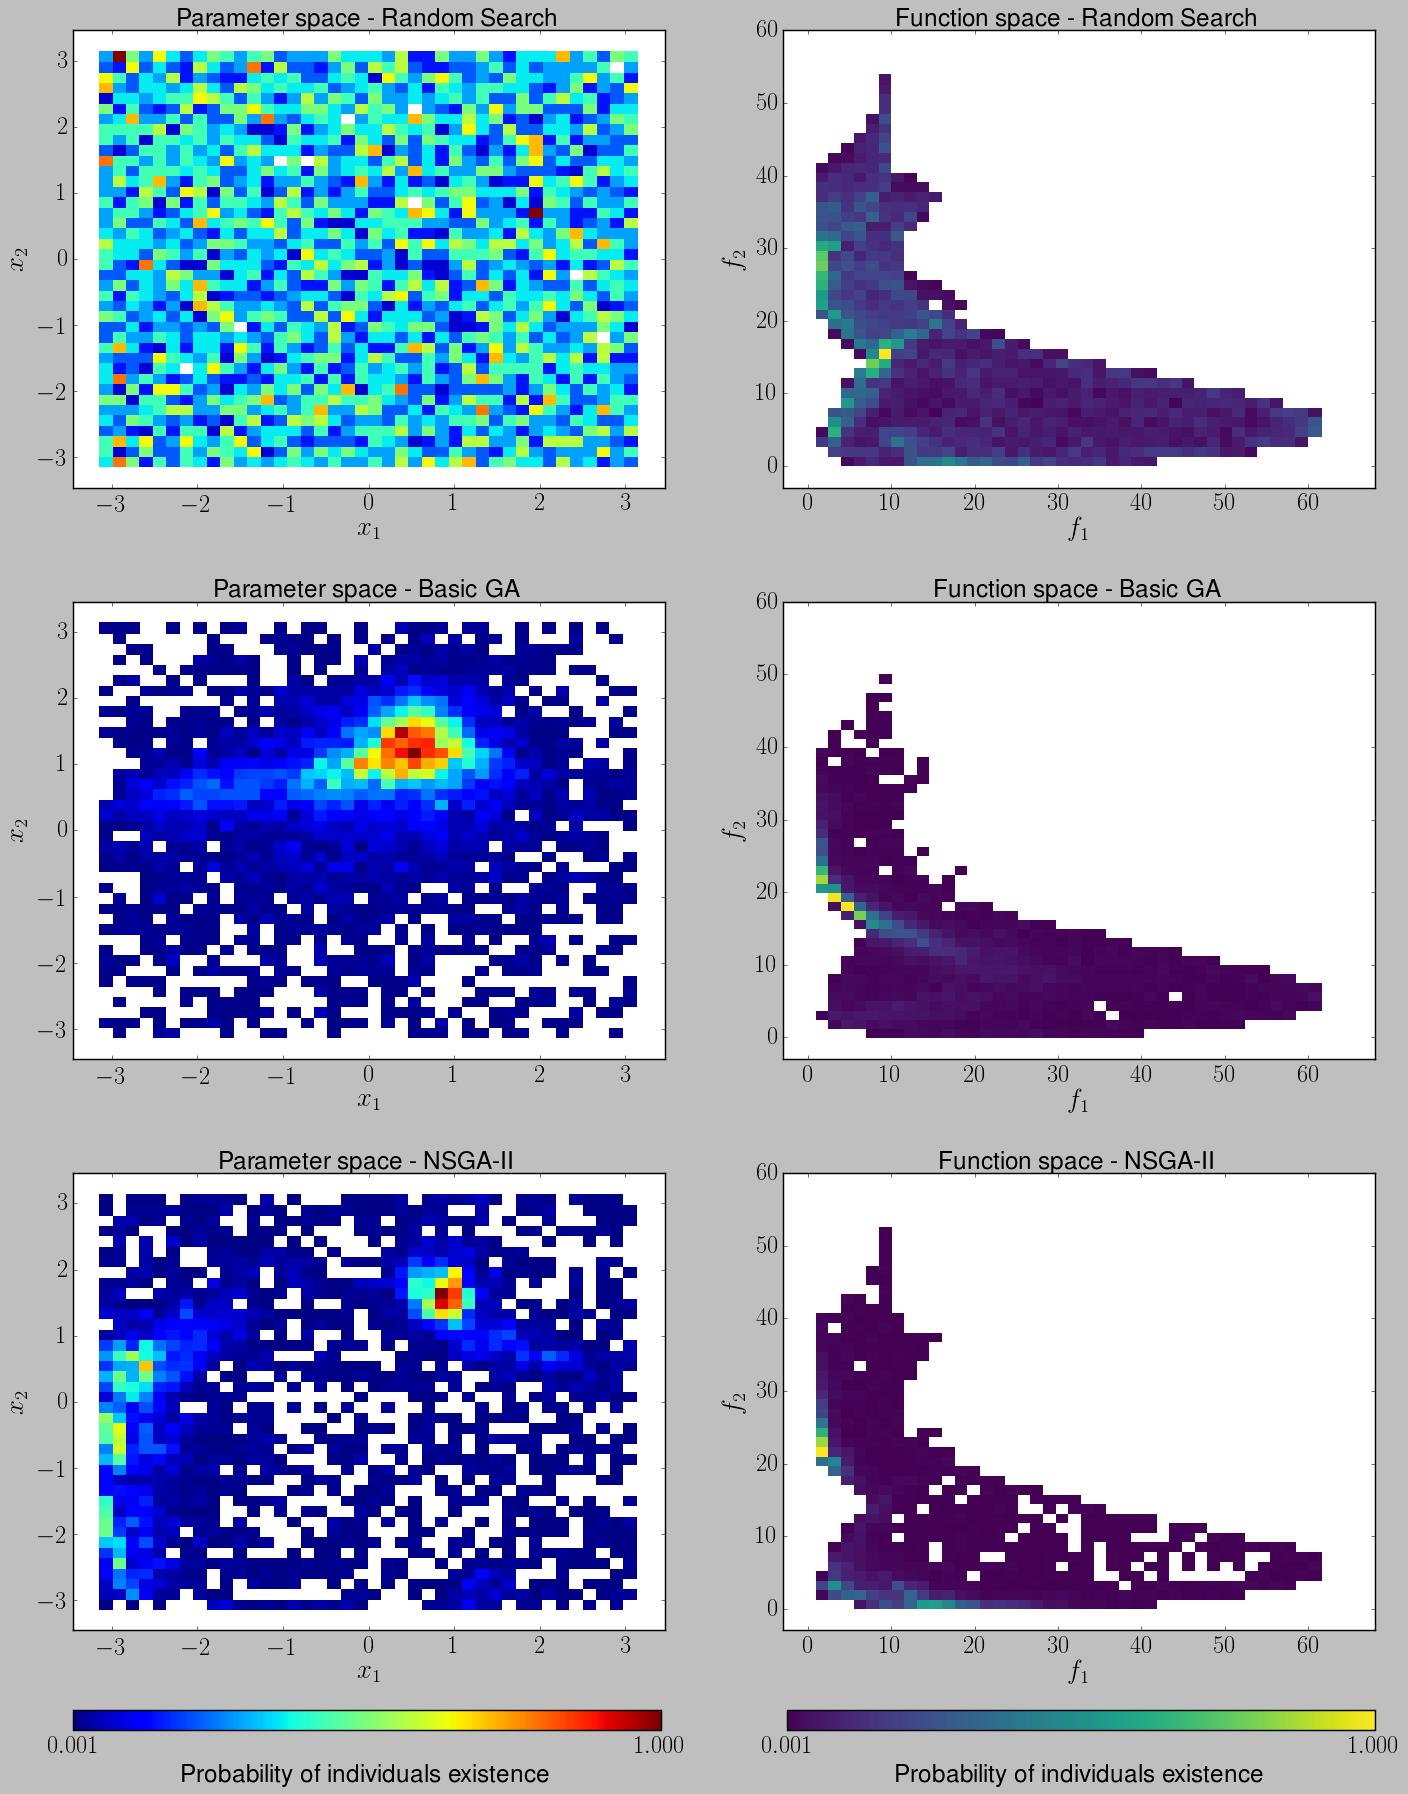

In [151]:
RSfe = []
RSp = []
GAEfe = []
GAEp = []
NSGAfe = []
NSGAp = []

RS_N = [80,90,100,110,200,225,250,275,450,500,550,600,900,1000,1100,1200]
GAE_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
GAE_g = [8,9,10,11,8,9,10,11,9,10,11,12,9,10,11,12]
NSGA_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
NSGA_g = [7,8,9,10,7,8,9,10,8,9,10,11,8,9,10,11]

for i in range(len(RS_N)):
    [RS_P,RS_funEval,_] = RS(RS_N[i])
    RSfe.append(RS_funEval)
    RSp.append(RS_P)
    
    [GAE_P,GAE_funEval,_] = GA_E(GAE_N[i], GAE_g[i], [1,0,0])
    GAEfe.append(np.reshape(GAE_funEval[:,:,:],[GAE_funEval[:,:,:].shape[0]*GAE_funEval[:,:,:].shape[1],GAE_funEval[:,:,:].shape[2]]))
    GAEp.append(np.reshape(GAE_P[:,:,:],[GAE_P[:,:,:].shape[0]*GAE_P[:,:,:].shape[1],GAE_P[:,:,:].shape[2]]))
   
    [NSGA_P,NSGA_funEval,_] = NSGA_II(NSGA_N[i], NSGA_g[i], [1,0,0])
    NSGAfe.append(np.vstack(NSGA_funEval))
    NSGAp.append(np.vstack(NSGA_P))
    
freqFECM = cm.viridis
freqFECM.set_under('w')
freqPCM = cm.jet
freqPCM.set_under('w')

binNo = 40

fig, ax = plt.subplots(3,2, figsize=(21,25))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[2][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.05, 0.35, 0.01])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', labelsize = 22)
cbar.set_label('Probability of individuals existence', fontsize=22)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[2][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.05, 0.35, 0.01])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', labelsize = 22)
ccbar.set_label('Probability of individuals existence', fontsize=22)

for i in range(3):
    ax[i][0].set_xlim([-1.1*np.pi,1.1*np.pi]);
    ax[i][0].set_ylim([-1.1*np.pi,1.1*np.pi]);
    ax[i][1].set_xlim([-3,68]);
    ax[i][1].set_ylim([-3,60]);

    ax[i][0].set_xlabel(r'$x_1$', fontsize = 24)
    ax[i][0].set_ylabel(r'$x_2$', fontsize = 24)
    ax[i][1].set_xlabel(r'$f_1$', fontsize = 24)
    ax[i][1].set_ylabel(r'$f_2$', fontsize = 24)
    ax[i][0].tick_params(axis = 'both', labelsize = 22)
    ax[i][1].tick_params(axis = 'both', labelsize = 22)

ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[1][0].set_title('Parameter space - Basic GA', fontsize = 22)
ax[1][1].set_title('Function space - Basic GA', fontsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
    
plt.savefig('./figures/hist_POL.pdf', bbox_inches='tight')

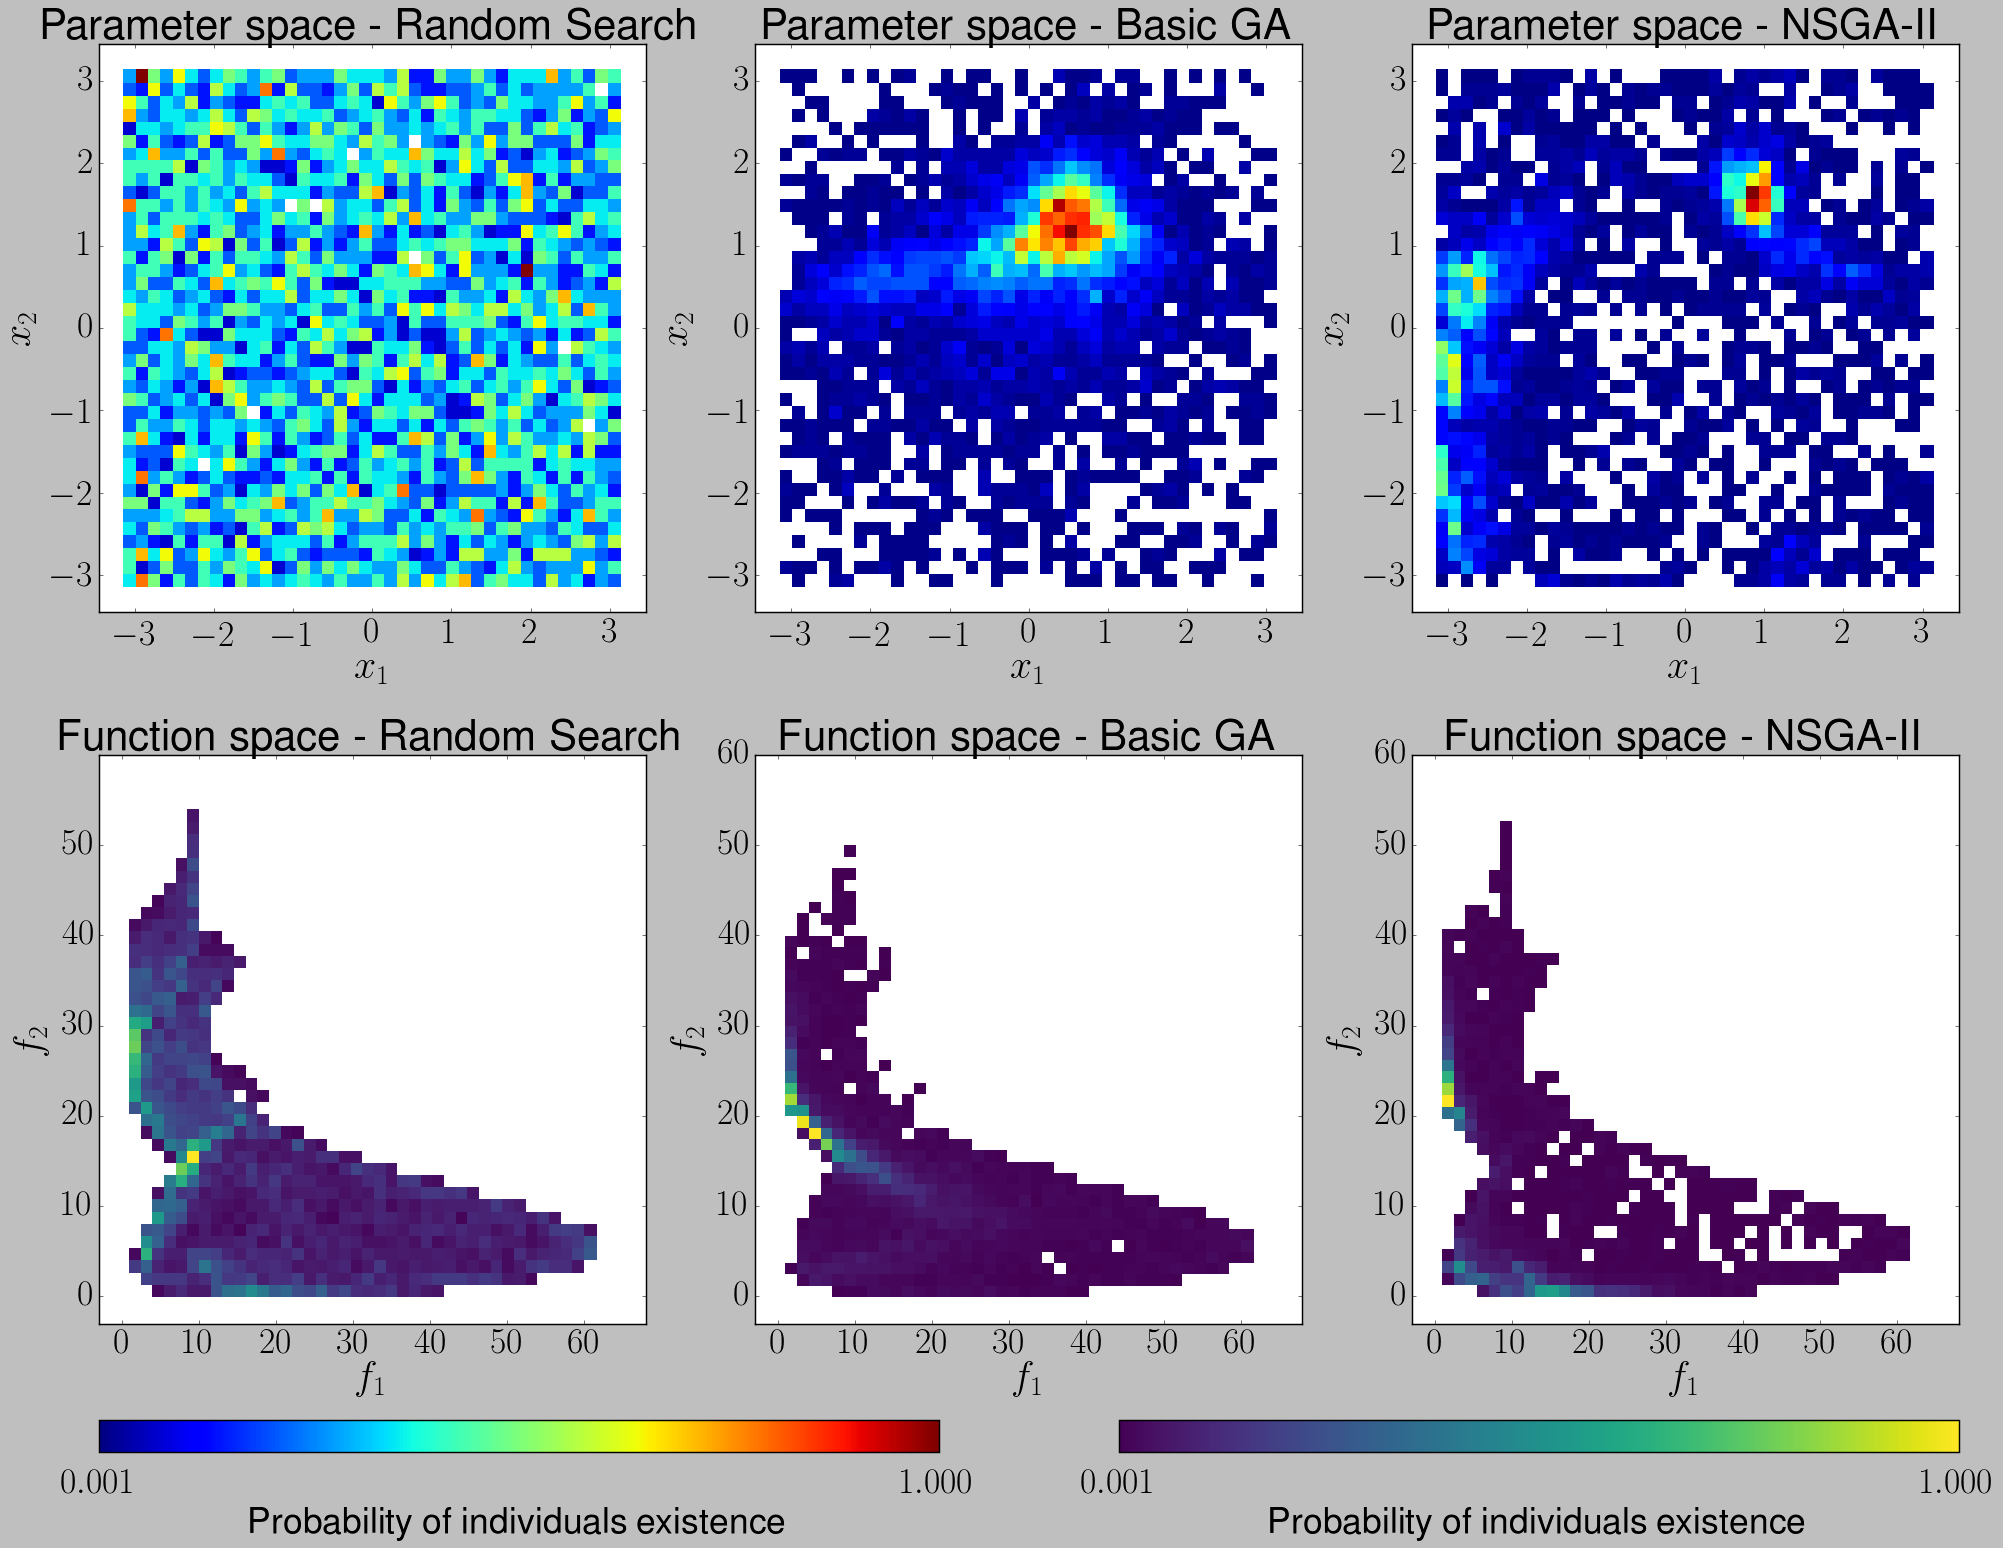

In [154]:
binNo = 40

fig, ax = plt.subplots(2,3, figsize=(30,20))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[0][2].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.02, 0.35, 0.02])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', pad = 15, labelsize = 32)
cbar.set_label('Probability of individuals existence', fontsize=32)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[1][2].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.02, 0.35, 0.02])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', pad = 15,labelsize = 32)
ccbar.set_label('Probability of individuals existence', fontsize=32)

labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
labels = ['$0$', '$0$','$10$','$20$','$30$','$40$','$50$','']
ax[1][0].set_yticklabels(labels)

for i in range(3):
    ax[0][i].set_xlim([-1.1*np.pi,1.1*np.pi]);
    ax[0][i].set_ylim([-1.1*np.pi,1.1*np.pi]);
    ax[1][i].set_xlim([-3,68]);
    ax[1][i].set_ylim([-3,60]);

    ax[0][i].set_xlabel(r'$x_1$', fontsize = 36)
    ax[0][i].set_ylabel(r'$x_2$', fontsize = 36)
    ax[1][i].set_xlabel(r'$f_1$', fontsize = 36)
    ax[1][i].set_ylabel(r'$f_2$', fontsize = 36)
    ax[0][i].tick_params(axis = 'both', labelsize = 32)
    ax[1][i].tick_params(axis = 'both', labelsize = 32)

ax[0][0].set_title('Parameter space - Random Search', fontsize = 38)
ax[1][0].set_title('Function space - Random Search', fontsize = 38)
ax[0][1].set_title('Parameter space - Basic GA', fontsize = 38)
ax[1][1].set_title('Function space - Basic GA', fontsize = 38)
ax[0][2].set_title('Parameter space - NSGA-II', fontsize = 38)
ax[1][2].set_title('Function space - NSGA-II', fontsize = 38)
    
plt.savefig('./figures/POL.pdf', bbox_inches='tight')

### 3.5 Metrics analysis (generation & individuals)

## 4. ZDT2

### 4.1 Functions

In [156]:
funNo = 2

def fun(x,y,no):
    """Objective function evaluation 
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the function that wants to be evaluated
    (although not an input, this function should be used with a defined funNo)

    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This will return the 'no' functions evaluated in x and y with the number of times 
    that the function has been called (this will be translated in CFD evaluations). 
    This follows Python notation where the first function is 0, the second is 1,...
    """
    
    # Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    
    # Conditional case for each one of the functions
    if no == 0:
        return x
    if no == 1:
        g = 1 + 9*(y)
        return g*(1-np.sqrt(x/g))

### 4.2 Domain

In [157]:
x_low = 0
x_high = 1
y_low = 0
y_high = 1

### 4.3 Constrains

In [158]:
def const(x,y,no):
    """Parameter space constraints for x and y values
    
    INPUTS:
    x:      first parameter search space component as numpy.ndarray
    y:      second parameter search space component as numpy.ndarray
    no:     number of the constraint that wants to be evaluated
    (although not an input, this function should be used with constVal and
    compMode lists that have the constraints values)
    
    OUTPUTS:
    array:  mutated individual as numpy.ndarray
    
    This function evaluates the constraints for the set of values in x and y in the
    desired function no-th. This follows Python notation where the first function is
    0, the second is 1,...
    """
    
    # Conditional for domain
    if no == 0:
        return x
    if no == 1:
        return x
    if no == 2:
        return y
    if no == 3:
        return y

In [159]:
constVal = [x_high, x_low, y_high, y_low]
compMode = ['leq', 'geq', 'leq', 'geq']

In [160]:
def constrainedPts(points, const, constVal, compMode):
    """Function that will constraint points out of bounds
    
    INPUTS:
    points:     points in the parameter search space as a numpy.ndarray
    const:      function with search space components and constraints number
    constVal:   comparison value for each constraint as list
    compMode:   comparison mode ('leq','geq','less','greater','equal') as list
    
    OUTPUTS:
    booleanMat: boolean matrix with 1 for the non valid points (constrained)
    
    This function will evaluate the constraints for all points in the set returning a 
    boolean masked matrix with the values that are constrained. It will raise an error
    in there is something wrong with the comparison mode. 
    """
    
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i],
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], 
                                         const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

### 4.4 Methods comparison

1000.0 1000.0 1000.0


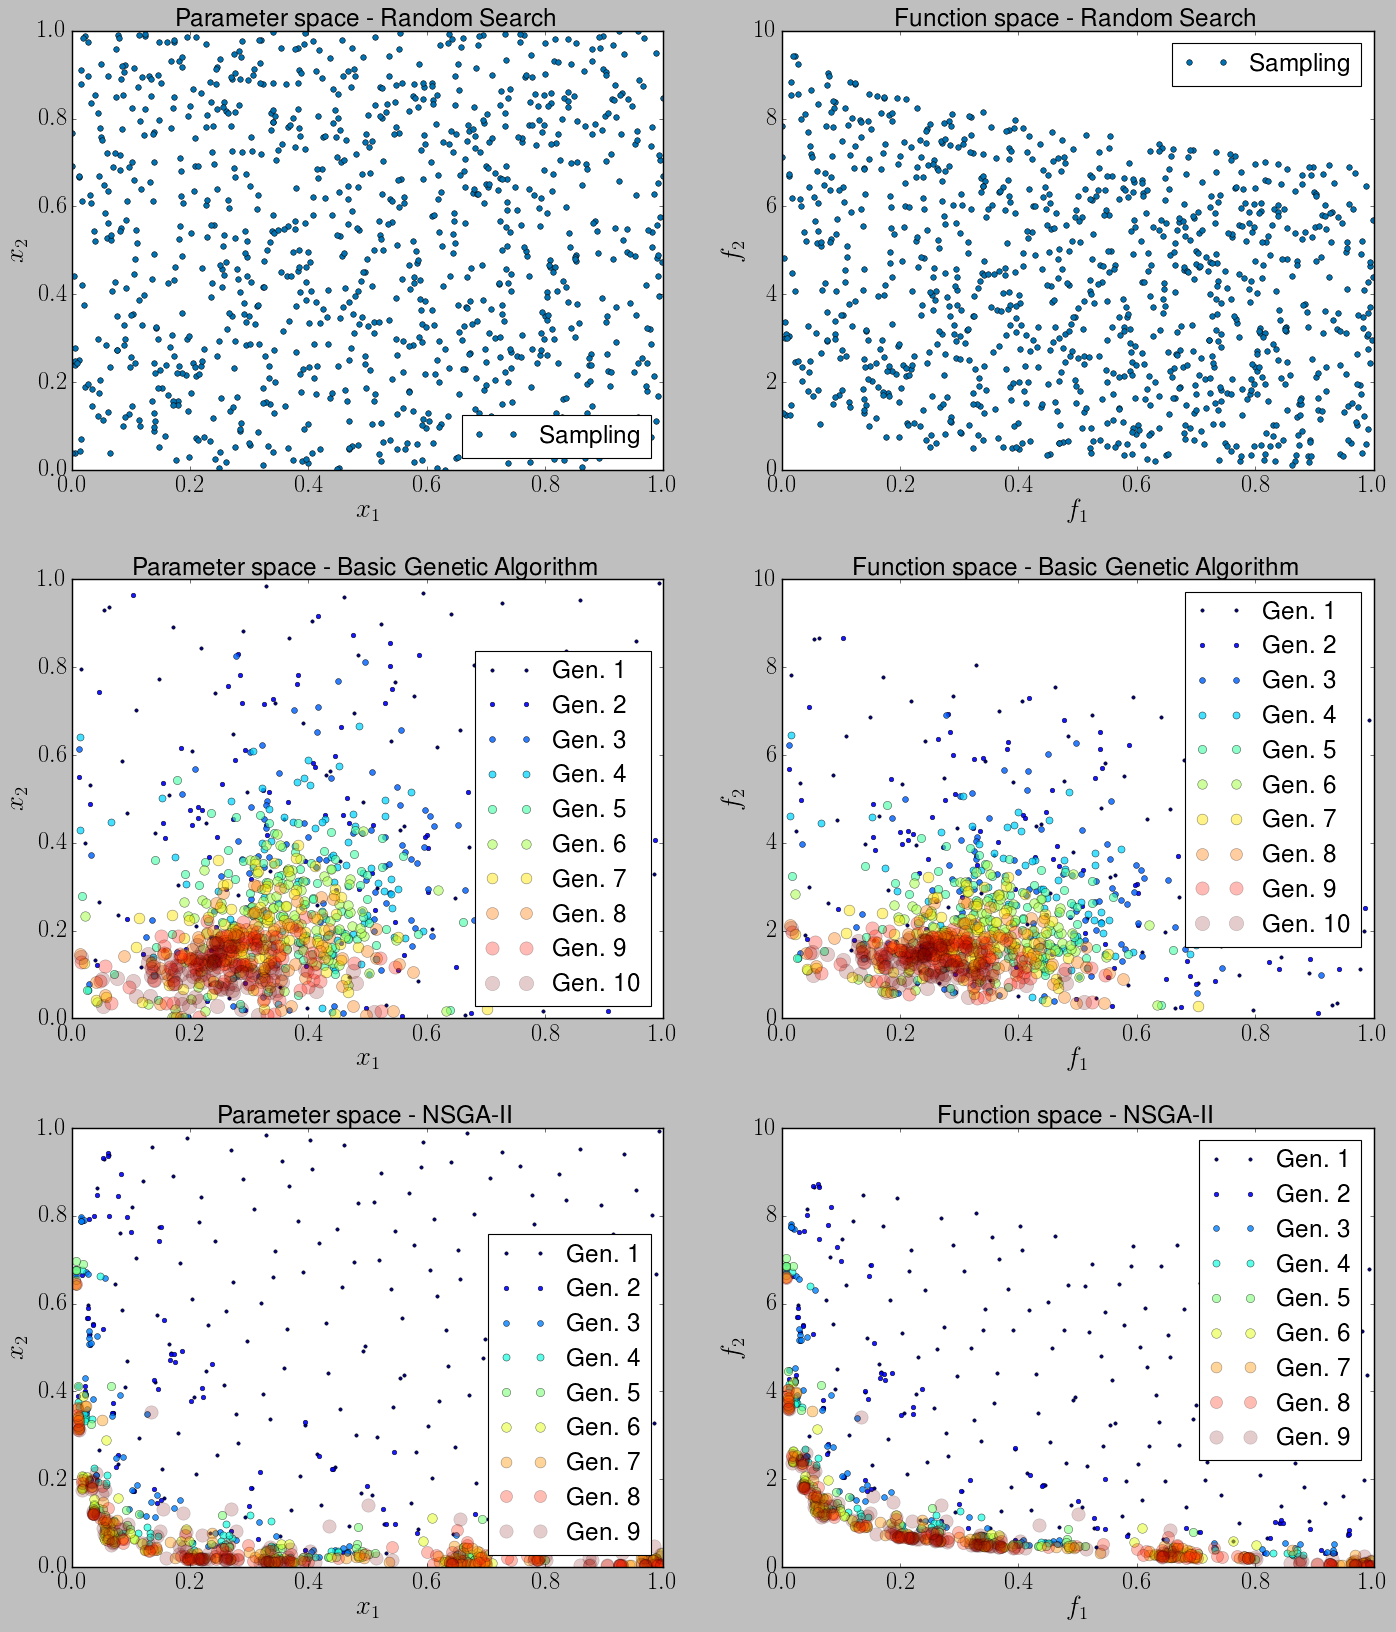

In [91]:
fig, ax = plt.subplots(3,2, figsize=(21,24))
plt.subplots_adjust(hspace = 0.25)

N = 1000
GAE_N = 100
GAE_g = 10
NSGA_N = 100
NSGA_g = 9

# Random search - Monte Carlo method
[RS_P,RS_funEval,RS_counter] = RS(N)
ax[0][0].plot(RS_P[:,0],RS_P[:,1],'o',label='Sampling',markersize=5)
ax[0][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[0][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[0][0].tick_params(axis = 'both', labelsize = 22)
ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][0].legend(loc = 'lower right' , fontsize = 22)
ax[0][1].plot(RS_funEval[:,0],RS_funEval[:,1],'o',label='Sampling',markersize=5)
ax[0][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[0][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[0][1].tick_params(axis = 'both', labelsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[0][1].legend(loc = 'upper right' , fontsize = 22)


# Custom genetic algorithm 
[GAE_P,GAE_funEval,GAE_counter] = GA_E(GAE_N, GAE_g, [0,1,0])

ms = np.linspace(3,len(GAE_P)+3,len(GAE_P))
al = np.linspace(1,0.2,len(GAE_P))
c = cm.jet(np.linspace(0,1,len(GAE_P)))

for i in range(len(GAE_P)):
    ax[1][0].plot(GAE_P[i,:,0],GAE_P[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
    ax[1][1].plot(GAE_funEval[i,:,0],GAE_funEval[i,:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[1][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[1][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[1][0].tick_params(axis = 'both', labelsize = 22)
ax[1][0].set_title('Parameter space - Basic Genetic Algorithm', fontsize = 22)
ax[1][0].legend(loc = 'lower right' , fontsize = 22)
ax[1][0].set_xlim(ax[0][0].get_xlim())
ax[1][0].set_ylim(ax[0][0].get_ylim())
ax[1][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[1][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[1][1].tick_params(axis = 'both', labelsize = 22)
ax[1][1].set_title('Function space - Basic Genetic Algorithm', fontsize = 22)
ax[1][1].legend(loc = 'upper right' , fontsize = 22)
ax[1][1].set_xlim(ax[0][1].get_xlim())
ax[1][1].set_ylim(ax[0][1].get_ylim())

# NSGA-II algorithm
[NSGA_P,NSGA_funEval,NSGA_counter] = NSGA_II(NSGA_N, NSGA_g, [0,1,0])

ms = np.linspace(3,3+len(NSGA_P),len(NSGA_P))
al = np.linspace(1,0.2,len(NSGA_P))
c = cm.jet(np.linspace(0,1,len(NSGA_P)))

for i in range(len(NSGA_P)):
    ax[2][0].plot(NSGA_P[i][:,0],NSGA_P[i][:,1],'o',label='Gen. %i' %(i+1), color=c[i],alpha=al[i],markersize=ms[i])
    ax[2][1].plot(NSGA_funEval[i][:,0],NSGA_funEval[i][:,1],'o',label='Gen. %i' %(i+1),color=c[i],alpha=al[i],markersize=ms[i])
ax[2][0].set_xlabel(r'$x_1$', fontsize = 24)
ax[2][0].set_ylabel(r'$x_2$', fontsize = 24)
ax[2][0].tick_params(axis = 'both', labelsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][0].set_xlim(ax[0][0].get_xlim())
ax[2][0].set_ylim(ax[0][0].get_ylim())
ax[2][0].legend(loc = 'lower right' , fontsize = 22)
ax[2][1].set_xlabel(r'$f_1$', fontsize = 24)
ax[2][1].set_ylabel(r'$f_2$', fontsize = 24)
ax[2][1].tick_params(axis = 'both', labelsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
ax[2][1].legend(loc = 'upper right' , fontsize = 22)
ax[2][1].set_xlim(ax[0][1].get_xlim())
ax[2][1].set_ylim(ax[0][1].get_ylim())

plt.savefig('./figures/random_ZDT2%i.pdf' %N, bbox_inches='tight')

print(RS_counter, GAE_counter, NSGA_counter)

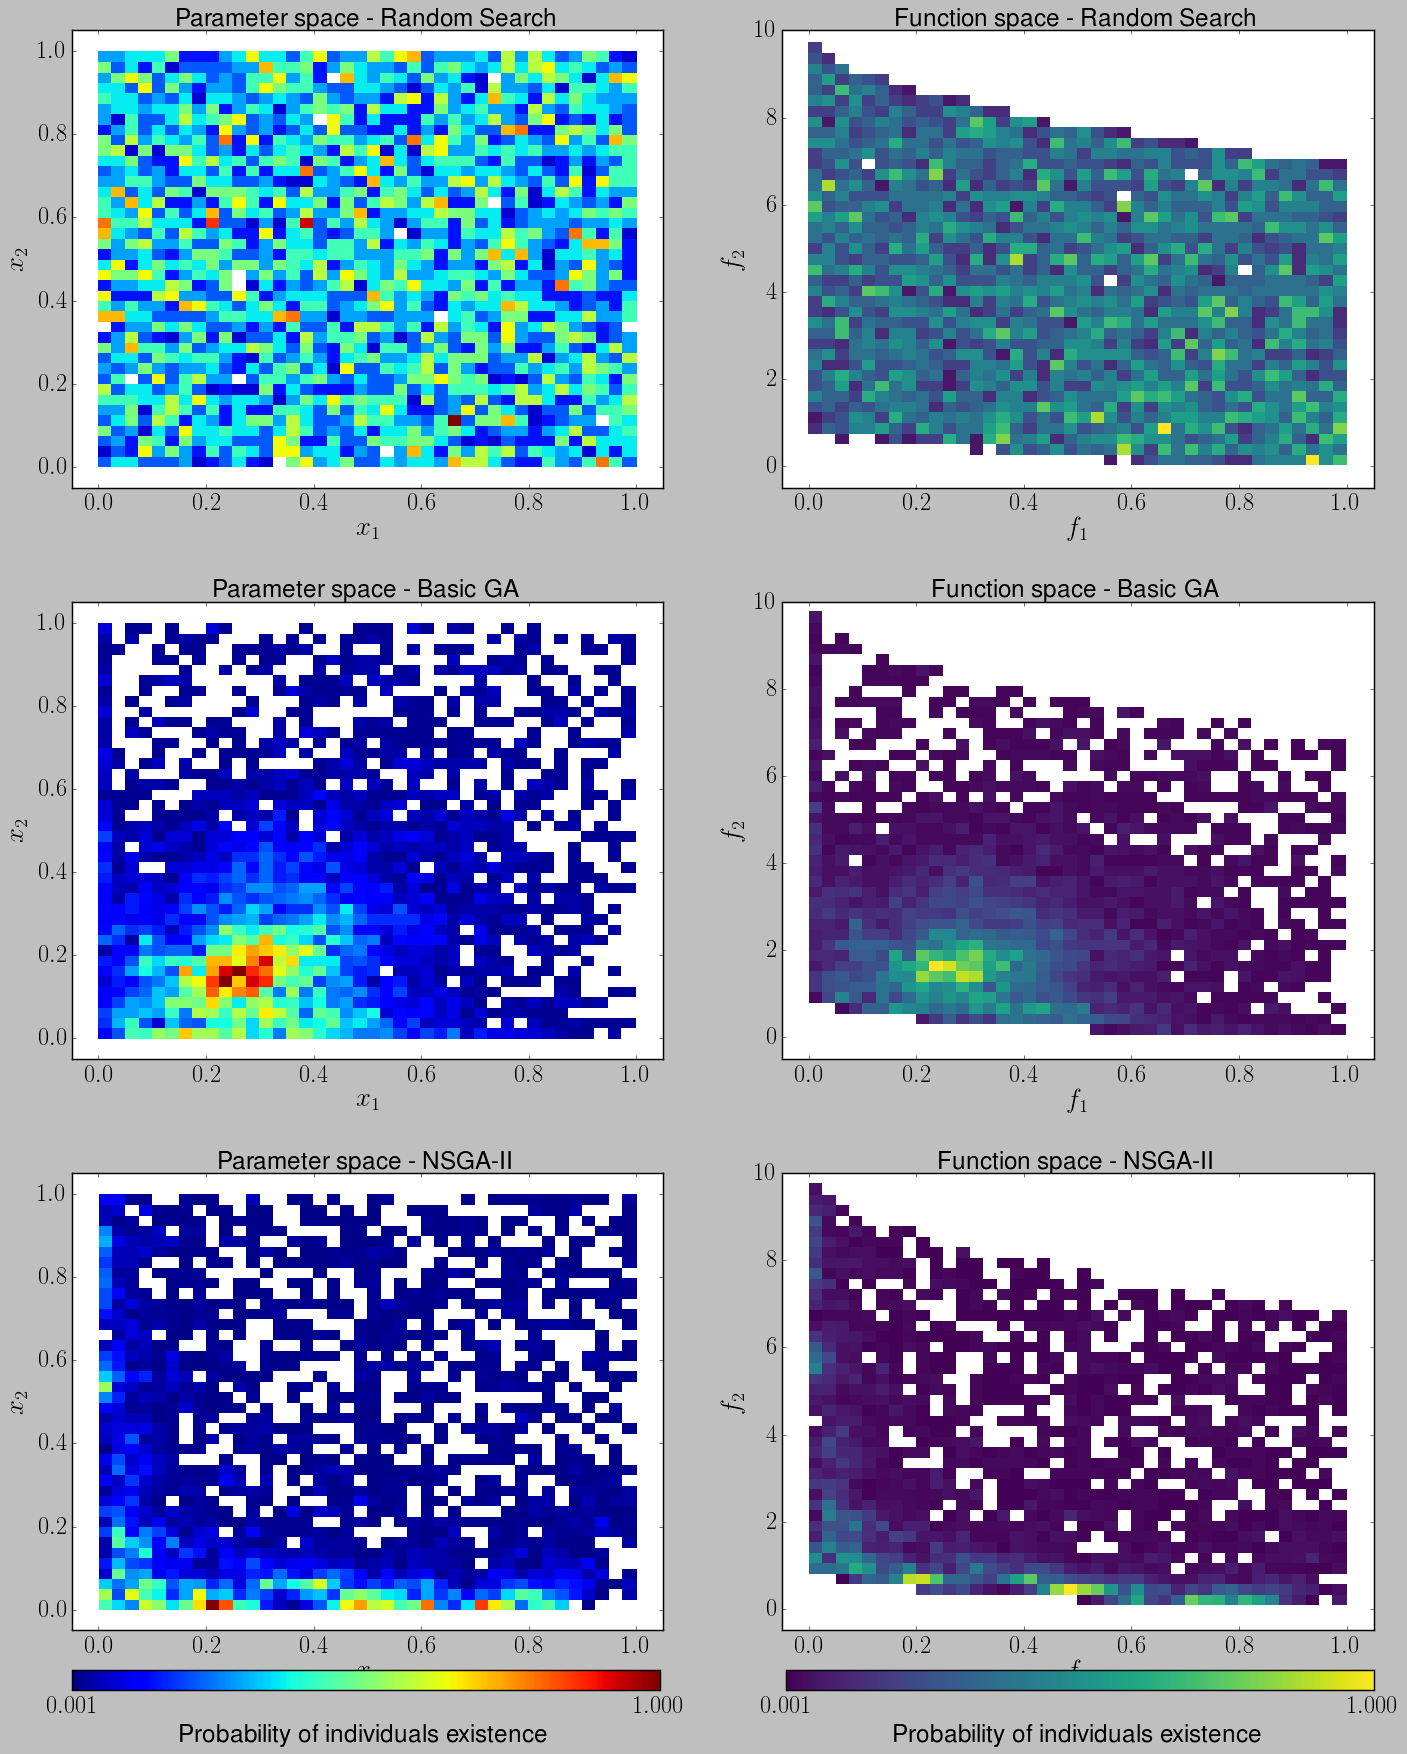

In [161]:
RSfe = []
RSp = []
GAEfe = []
GAEp = []
NSGAfe = []
NSGAp = []

RS_N = [80,90,100,110,200,225,250,275,450,500,550,600,900,1000,1100,1200]
GAE_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
GAE_g = [8,9,10,11,8,9,10,11,9,10,11,12,9,10,11,12]
NSGA_N = [10,10,10,10,25,25,25,25,50,50,50,50,100,100,100,100]
NSGA_g = [7,8,9,10,7,8,9,10,8,9,10,11,8,9,10,11]

for i in range(len(RS_N)):
    [RS_P,RS_funEval,_] = RS(RS_N[i])
    RSfe.append(RS_funEval)
    RSp.append(RS_P)
    
    [GAE_P,GAE_funEval,_] = GA_E(GAE_N[i], GAE_g[i], [1,0,0])
    GAEfe.append(np.reshape(GAE_funEval[:,:,:],[GAE_funEval[:,:,:].shape[0]*GAE_funEval[:,:,:].shape[1],GAE_funEval[:,:,:].shape[2]]))
    GAEp.append(np.reshape(GAE_P[:,:,:],[GAE_P[:,:,:].shape[0]*GAE_P[:,:,:].shape[1],GAE_P[:,:,:].shape[2]]))
   
    [NSGA_P,NSGA_funEval,_] = NSGA_II(NSGA_N[i], NSGA_g[i], [1,0,0])
    NSGAfe.append(np.vstack(NSGA_funEval))
    NSGAp.append(np.vstack(NSGA_P))
    
freqFECM = cm.viridis
freqFECM.set_under('w')
freqPCM = cm.jet
freqPCM.set_under('w')

binNo = 40

fig, ax = plt.subplots(3,2, figsize=(21,25))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[2][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.07, 0.35, 0.01])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', labelsize = 22)
cbar.set_label('Probability of individuals existence', fontsize=22)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[2][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.07, 0.35, 0.01])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', labelsize = 22)
ccbar.set_label('Probability of individuals existence', fontsize=22)

for i in range(3):
    ax[i][0].set_xlim([-0.05,1.05]);
    ax[i][0].set_ylim([-0.05,1.05]);
    ax[i][1].set_xlim([-0.05,1.05]);
    ax[i][1].set_ylim([-0.5,10]);
    
    ax[i][0].set_xlabel(r'$x_1$', fontsize = 24)
    ax[i][0].set_ylabel(r'$x_2$', fontsize = 24)
    ax[i][1].set_xlabel(r'$f_1$', fontsize = 24)
    ax[i][1].set_ylabel(r'$f_2$', fontsize = 24)
    ax[i][0].tick_params(axis = 'both', labelsize = 22)
    ax[i][1].tick_params(axis = 'both', labelsize = 22)

ax[0][0].set_title('Parameter space - Random Search', fontsize = 22)
ax[0][1].set_title('Function space - Random Search', fontsize = 22)
ax[1][0].set_title('Parameter space - Basic GA', fontsize = 22)
ax[1][1].set_title('Function space - Basic GA', fontsize = 22)
ax[2][0].set_title('Parameter space - NSGA-II', fontsize = 22)
ax[2][1].set_title('Function space - NSGA-II', fontsize = 22)
    
plt.savefig('./figures/hist_ZDT2.pdf', bbox_inches='tight')

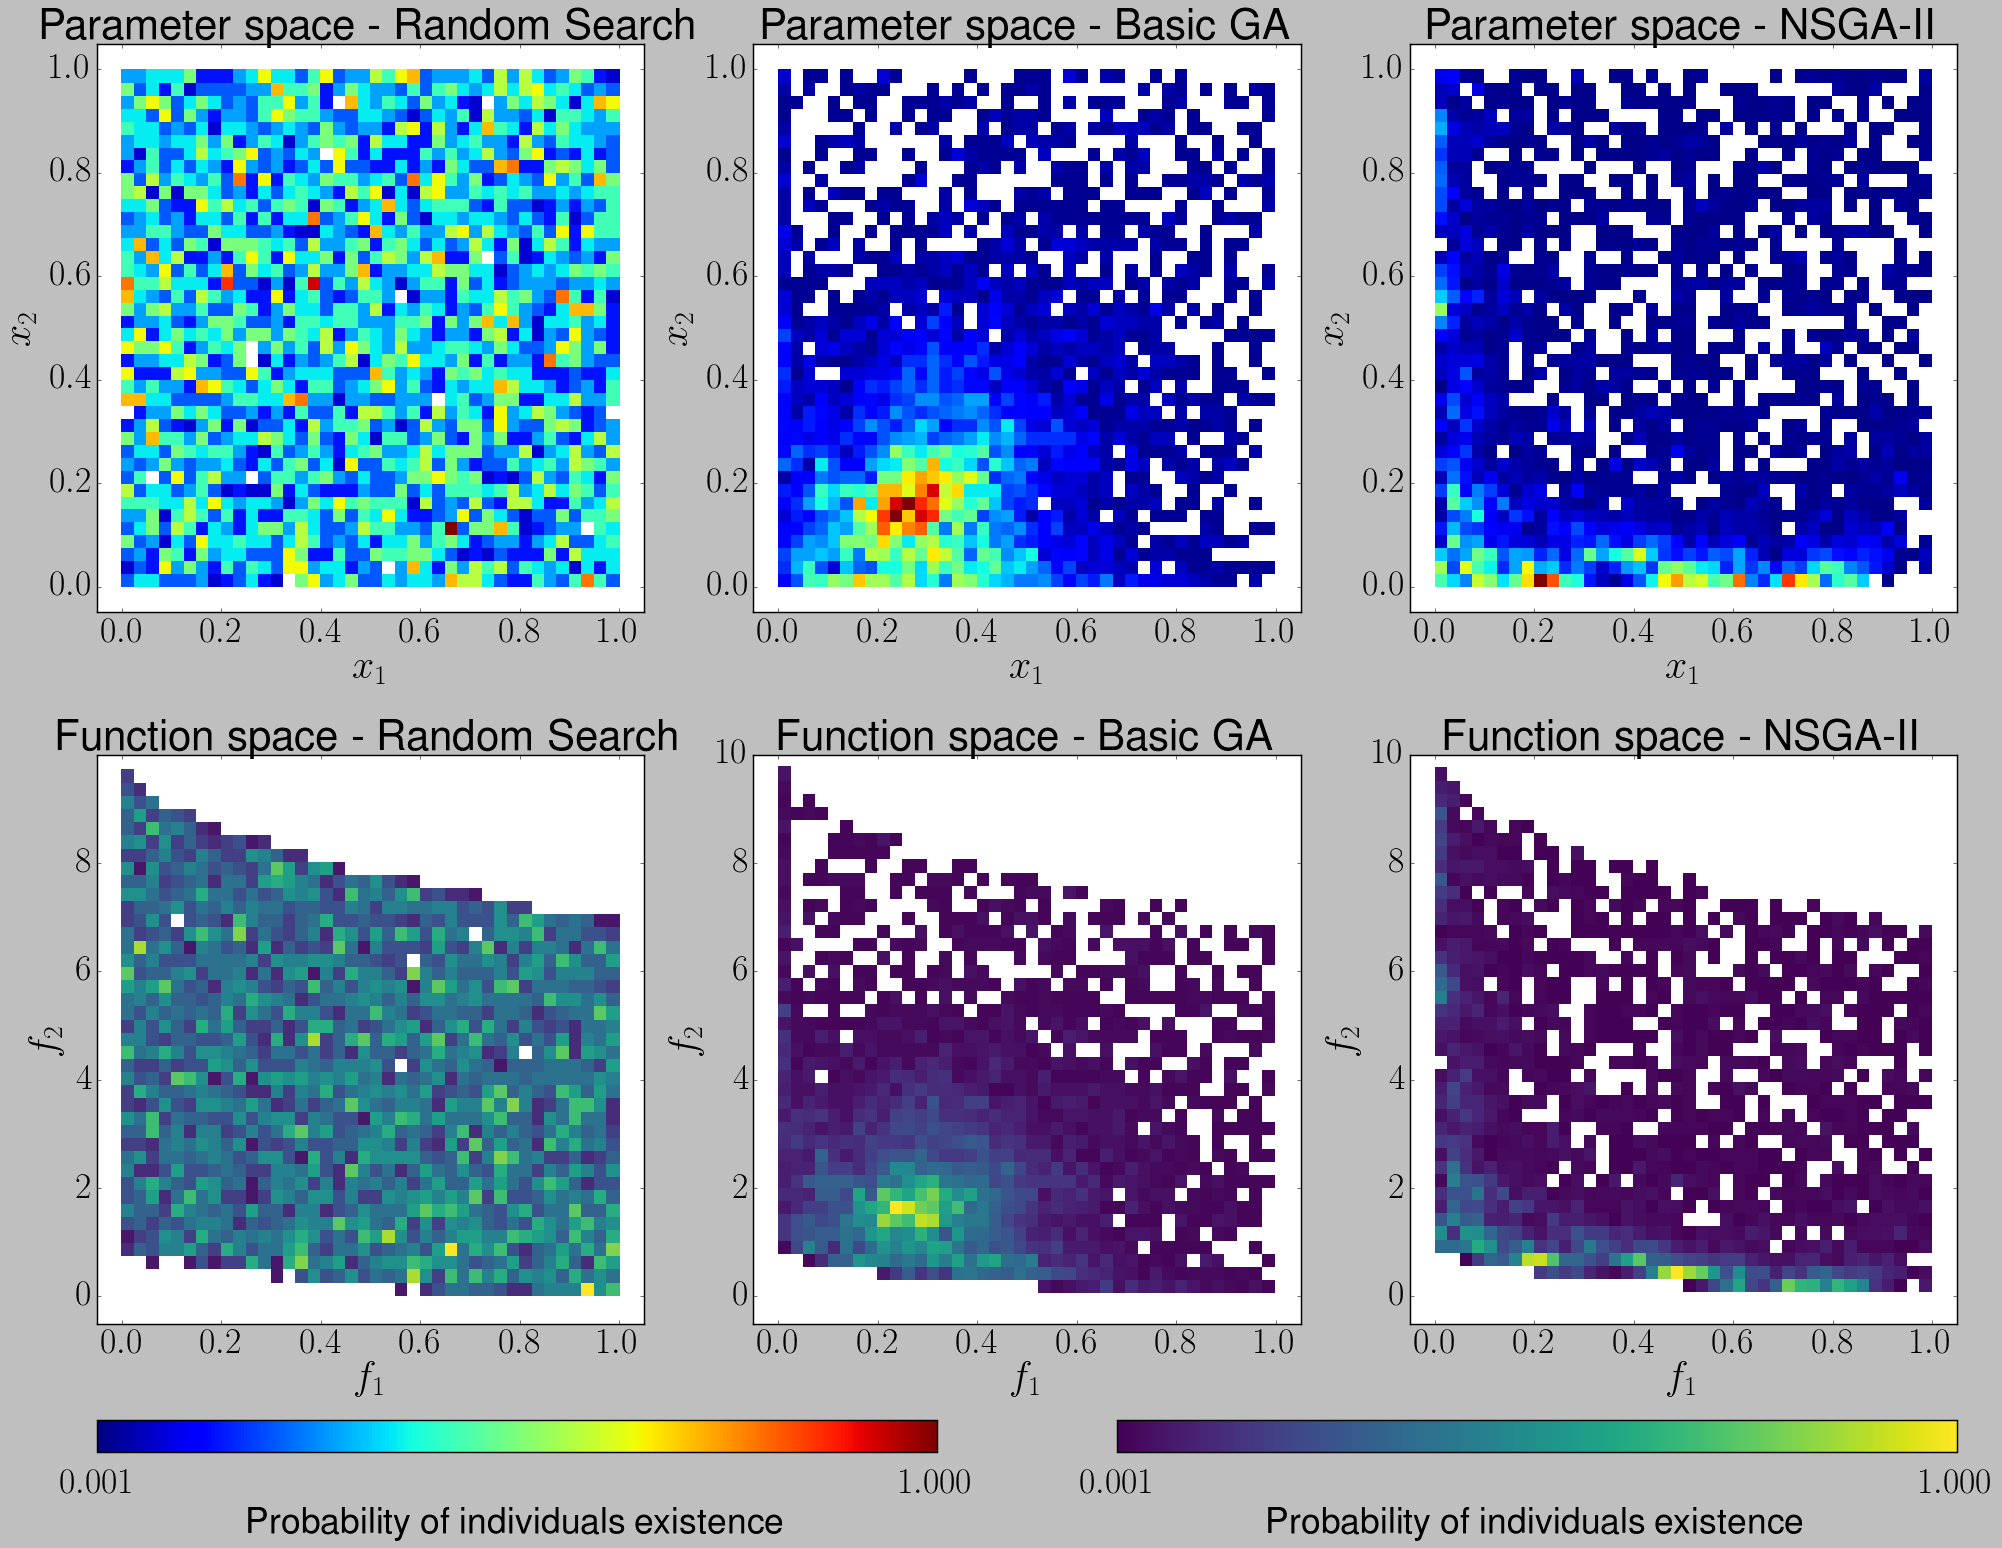

In [163]:
binNo = 40

fig, ax = plt.subplots(2,3, figsize=(30,20))
plt.subplots_adjust(hspace = 0.25)

H, xedges, yedges = np.histogram2d(np.vstack(RSp)[:,0], np.vstack(RSp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][0].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(RSfe)[:,0], np.vstack(RSfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][0].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEp)[:,0], np.vstack(GAEp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[0][1].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(GAEfe)[:,0], np.vstack(GAEfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
ax[1][1].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAp)[:,0], np.vstack(NSGAp)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
leftIm = ax[0][2].pcolormesh(X, Y, H/H.max(), cmap=freqPCM, vmin=0.001)
cax = fig.add_axes([0.125, 0.02, 0.35, 0.02])
cbar = fig.colorbar(leftIm,  cax=cax, orientation="horizontal")
cbar.set_ticks([0.001,1.0])
cax.tick_params(axis = 'both', pad = 15, labelsize = 32)
cbar.set_label('Probability of individuals existence', fontsize=32)

H, xedges, yedges = np.histogram2d(np.vstack(NSGAfe)[:,0], np.vstack(NSGAfe)[:,1], bins=binNo)
H = H.T 
X, Y = np.meshgrid(xedges, yedges)
rightIm = ax[1][2].pcolormesh(X, Y, H/H.max(), cmap=freqFECM, vmin=0.001)
ccax = fig.add_axes([0.55, 0.02, 0.35, 0.02])
ccbar = fig.colorbar(rightIm,  cax=ccax, orientation="horizontal")
ccbar.set_ticks([0.001,1.0])
ccax.tick_params(axis = 'both', pad = 15,labelsize = 32)
ccbar.set_label('Probability of individuals existence', fontsize=32)

for i in range(3):
    ax[0][i].set_xlim([-0.05,1.05]);
    ax[0][i].set_ylim([-0.05,1.05]);
    ax[1][i].set_xlim([-0.05,1.05]);   
    ax[1][i].set_ylim([-0.5,10]); 
    
    ax[0][i].set_xlabel(r'$x_1$', fontsize = 36)
    ax[0][i].set_ylabel(r'$x_2$', fontsize = 36)
    ax[1][i].set_xlabel(r'$f_1$', fontsize = 36)
    ax[1][i].set_ylabel(r'$f_2$', fontsize = 36)
    ax[0][i].tick_params(axis = 'both', labelsize = 32)
    ax[1][i].tick_params(axis = 'both', labelsize = 32)

labels = [item.get_text() for item in ax[1][0].get_yticklabels()]
labels = ['$0$','$0$','$2$','$4$','$6$','$8$','']
ax[1][0].set_yticklabels(labels)
    
ax[0][0].set_title('Parameter space - Random Search', fontsize = 38)
ax[1][0].set_title('Function space - Random Search', fontsize = 38)
ax[0][1].set_title('Parameter space - Basic GA', fontsize = 38)
ax[1][1].set_title('Function space - Basic GA', fontsize = 38)
ax[0][2].set_title('Parameter space - NSGA-II', fontsize = 38)
ax[1][2].set_title('Function space - NSGA-II', fontsize = 38)
    
plt.savefig('./figures/ZDT.pdf', bbox_inches='tight')

### 4.5 Metrics analysis (generation & individuals)

# 5. Metric analysis plot generation

## 5.1 Bihn and Kohn function

In [44]:
runs = 20

NSGA_N = 5*[8]+5*[16]+5*[32]+4*[64]+3*[128]
NSGA_g = [79,63,47,31,15,39,31,23,15,7,19,15,11,7,3,9,7,5,3,4,3,2]

ev640 = np.array([0,5,10,15,19])
ev512 = np.array([1,6,11,16,20])
ev384 = np.array([2,7,12,17,21])
ev256 = np.array([3,8,13,18])
ev128 = np.array([4,9,14])

convMetric = np.load('./comparisonData/convMetricBK.npy')
diverMetric = np.load('./comparisonData/diverMetricBK.npy')

convMean = np.mean(convMetric,axis=1)
convStd = np.std(convMetric,axis=1)

diverMean = np.mean(diverMetric,axis=1)
diverStd = np.std(diverMetric,axis=1)

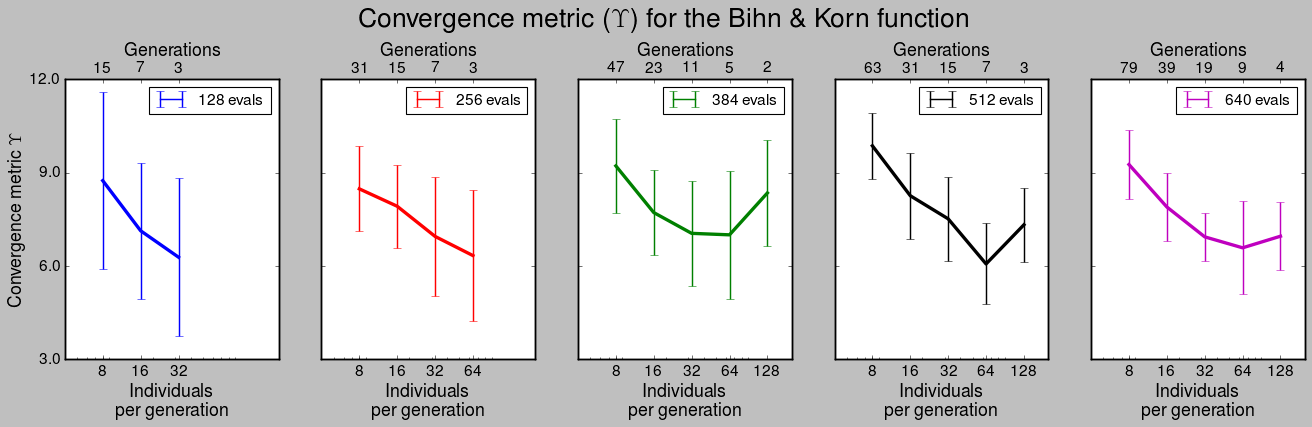

In [45]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([3,12]) 
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], convMean[ev128], convStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], convMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
# ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Convergence metric $\Upsilon$', fontsize=16)
ax[0].set_yticks([3.0,6.0,9.0,12.0])
ax[0].set_yticklabels([3.0,6.0,9.0,12.0], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], convMean[ev256], convStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], convMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], convMean[ev384], convStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], convMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], convMean[ev512], convStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], convMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], convMean[ev640], convStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], convMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Convergence metric ($\Upsilon$) for the Bihn \& Korn function", fontsize=24)

plt.savefig('./figures/convMetric_BK.pdf', bbox_inches='tight')

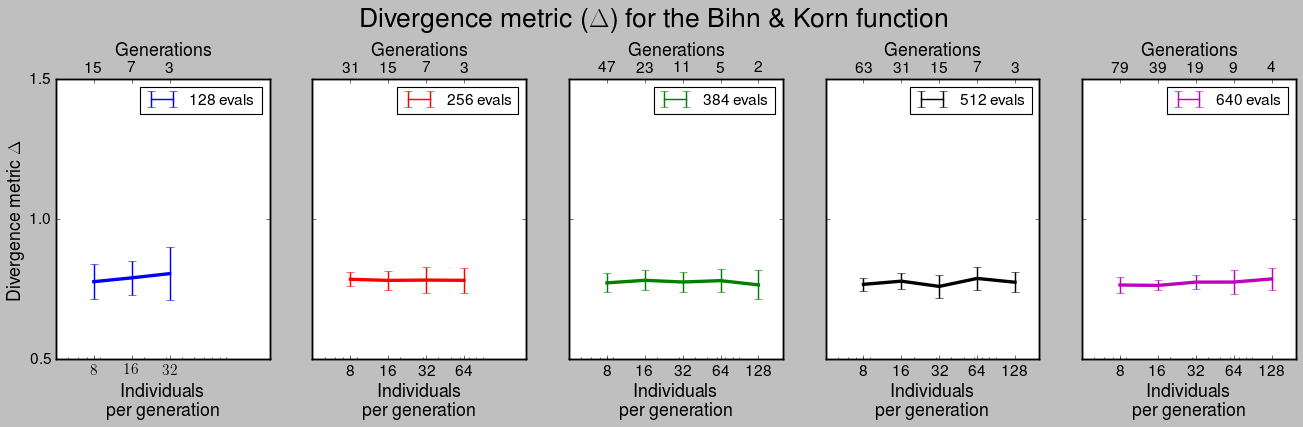

In [46]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([0.5,1.5])
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], diverMean[ev128], diverStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], diverMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Divergence metric $\Delta$', fontsize=16)
ax[0].set_yticks([0.5,1.0,1.5])
ax[0].set_yticklabels([0.5,1.0,1.5], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], diverMean[ev256], diverStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], diverMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], diverMean[ev384], diverStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], diverMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], diverMean[ev512], diverStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], diverMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], diverMean[ev640], diverStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], diverMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Divergence metric ($\Delta$) for the Bihn \& Korn function", fontsize=24)

plt.savefig('./figures/diverMetric_BK.pdf', bbox_inches='tight')

## 5.2 Poloni's function


In [47]:
convMetric = np.load('./comparisonData/convMetricPOL.npy')
diverMetric = np.load('./comparisonData/diverMetricPOL.npy')

convMean = np.mean(convMetric,axis=1)
convStd = np.std(convMetric,axis=1)

diverMean = np.mean(diverMetric,axis=1)
diverStd = np.std(diverMetric,axis=1)

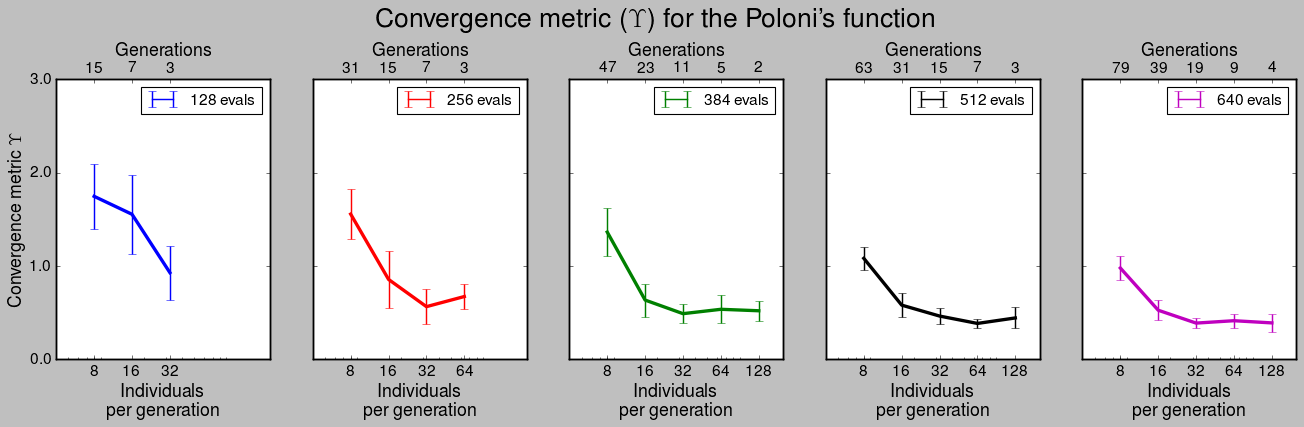

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([0,3])
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], convMean[ev128], convStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], convMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
# ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Convergence metric $\Upsilon$', fontsize=16)
ax[0].set_yticks([0.0,1.0,2.0,3.0])
ax[0].set_yticklabels([0.0,1.0,2.0,3.0], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], convMean[ev256], convStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], convMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], convMean[ev384], convStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], convMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], convMean[ev512], convStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], convMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], convMean[ev640], convStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], convMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Convergence metric ($\Upsilon$) for the Poloni's function", fontsize=24)

plt.savefig('./figures/convMetric_POL.pdf', bbox_inches='tight')

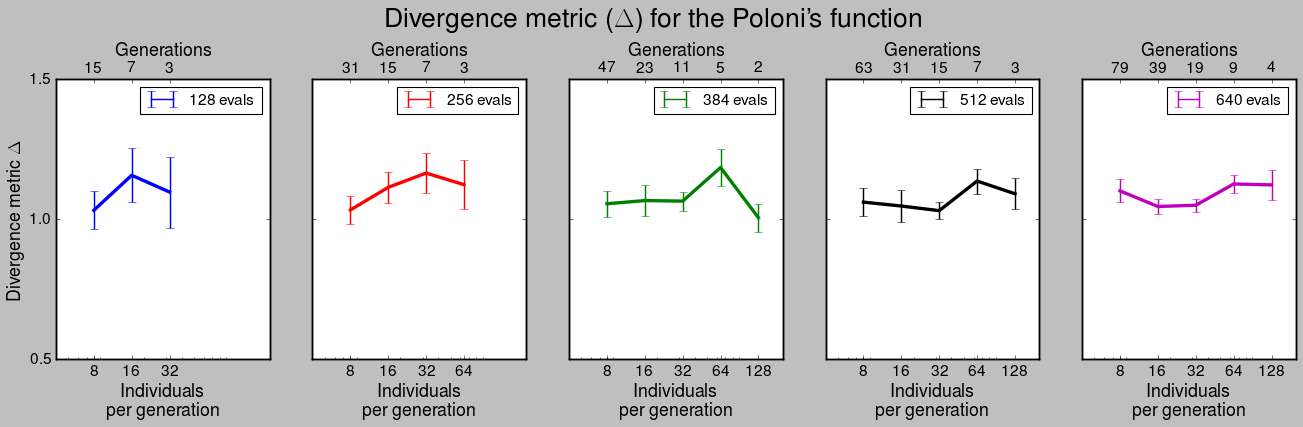

In [49]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([0.5,1.5])
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], diverMean[ev128], diverStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], diverMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
# ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Divergence metric $\Delta$', fontsize=16)
ax[0].set_yticks([0.5,1.0,1.5])
ax[0].set_yticklabels([0.5,1.0,1.5], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], diverMean[ev256], diverStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], diverMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], diverMean[ev384], diverStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], diverMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], diverMean[ev512], diverStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], diverMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], diverMean[ev640], diverStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], diverMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Divergence metric ($\Delta$) for the Poloni's function", fontsize=24)

plt.savefig('./figures/diverMetric_POL.pdf', bbox_inches='tight')

## 5.3 ZDT 2

In [50]:
convMetric = np.load('./comparisonData/convMetricZDT.npy')
diverMetric = np.load('./comparisonData/diverMetricZDT.npy')

convMean = np.mean(convMetric,axis=1)
convStd = np.std(convMetric,axis=1)

diverMean = np.mean(diverMetric,axis=1)
diverStd = np.std(diverMetric,axis=1)

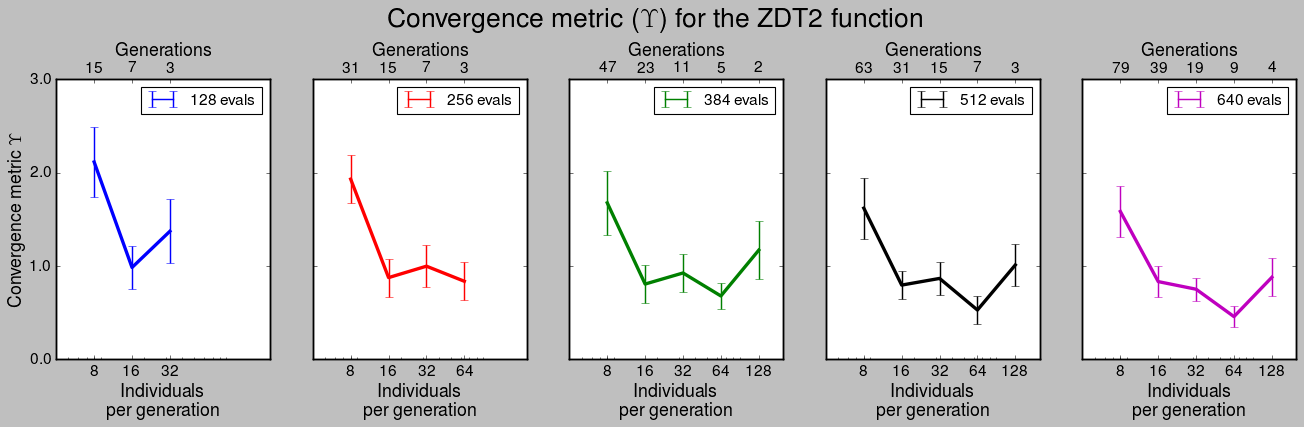

In [51]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([0,3])
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], convMean[ev128], convStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], convMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
# ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Convergence metric $\Upsilon$', fontsize=16)
ax[0].set_yticks([0.0,1.0,2.0,3.0])
ax[0].set_yticklabels([0.0,1.0,2.0,3.0], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], convMean[ev256], convStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], convMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], convMean[ev384], convStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], convMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], convMean[ev512], convStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], convMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], convMean[ev640], convStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], convMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Convergence metric ($\Upsilon$) for the ZDT2 function", fontsize=24)

plt.savefig('./figures/convMetric_ZDT.pdf', bbox_inches='tight')

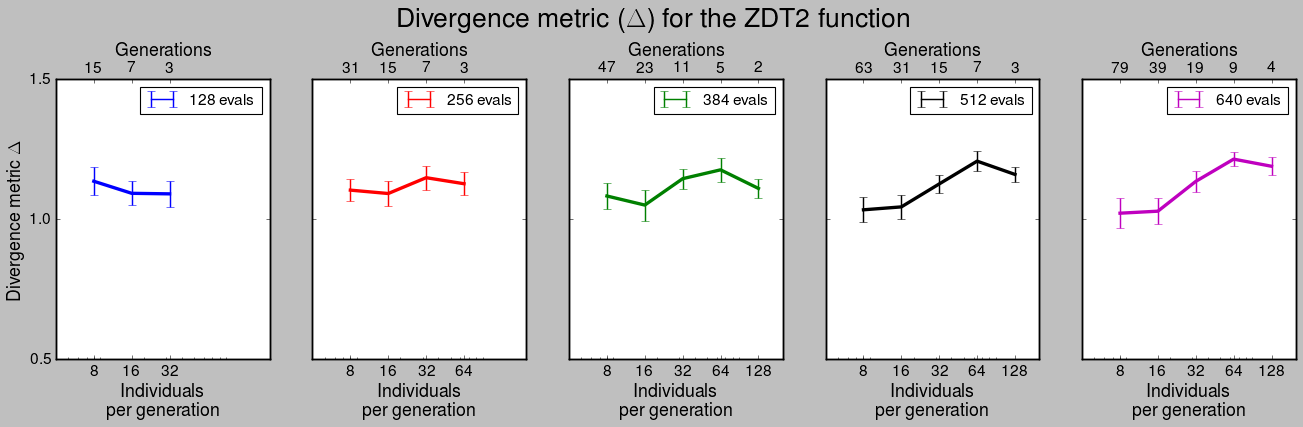

In [52]:
fig, ax = plt.subplots(1, 5, figsize=(20,5), sharey = 'row')
for i in range(5):
    ax[i].set_xscale("log", nonposx='clip')
    ax[i].set_ylim([0.5,1.5])
    ax[i].set_xlim([4,200])
    ax[i].set_xlabel('Individuals \n per generation', fontsize=16)

ax[0].errorbar(np.array(NSGA_N)[ev128], diverMean[ev128], diverStd[ev128], c='b', capsize=4, label='128 evals')
ax[0].plot(np.array(NSGA_N)[ev128], diverMean[ev128], c='b', linewidth=3)
ax[0].set_xticks(np.array(NSGA_N)[ev128])
ax[0].set_xticklabels(np.array(NSGA_N)[ev128], fontsize=14)
# ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[0].legend(loc='upper right', fontsize=14)
ax[0].set_ylabel(r'Divergence metric $\Delta$', fontsize=16)
ax[0].set_yticks([0.5,1.0,1.5])
ax[0].set_yticklabels([0.5,1.0,1.5], fontsize=14)
ax1 = ax[0].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev128])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev128], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[1].errorbar(np.array(NSGA_N)[ev256], diverMean[ev256], diverStd[ev256], c='r', capsize=4, label='256 evals')
ax[1].plot(np.array(NSGA_N)[ev256], diverMean[ev256], c='r', linewidth=3)
ax[1].set_xticks(np.array(NSGA_N)[ev256])
ax[1].set_xticklabels(np.array(NSGA_N)[ev256], fontsize=14)
# ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[1].legend(loc='upper right', fontsize=14)
ax1 = ax[1].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev256])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev256], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[2].errorbar(np.array(NSGA_N)[ev384], diverMean[ev384], diverStd[ev384], c='g', capsize=4, label='384 evals')
ax[2].plot(np.array(NSGA_N)[ev384], diverMean[ev384], c='g', linewidth=3)
ax[2].set_xticks(np.array(NSGA_N)[ev384])
ax[2].set_xticklabels(np.array(NSGA_N)[ev384], fontsize=14)
# ax[2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[2].legend(loc='upper right', fontsize=14)
ax1 = ax[2].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev384])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev384], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[3].errorbar(np.array(NSGA_N)[ev512], diverMean[ev512], diverStd[ev512], c='k', capsize=4, label='512 evals')
ax[3].plot(np.array(NSGA_N)[ev512], diverMean[ev512], c='k', linewidth=3)
ax[3].set_xticks(np.array(NSGA_N)[ev512])
ax[3].set_xticklabels(np.array(NSGA_N)[ev512], fontsize=14)
# ax[3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[3].legend(loc='upper right', fontsize=14)
ax1 = ax[3].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev512])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev512], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

ax[4].errorbar(np.array(NSGA_N)[ev640], diverMean[ev640], diverStd[ev640], c='m', capsize=4, label='640 evals')
ax[4].plot(np.array(NSGA_N)[ev640], diverMean[ev640], c='m', linewidth=3)
ax[4].set_xticks(np.array(NSGA_N)[ev640])
ax[4].set_xticklabels(np.array(NSGA_N)[ev640], fontsize=14)
# ax[4].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax[4].legend(loc='upper right', fontsize=14)
ax1 = ax[4].twiny()
ax1.set_xscale("log", nonposx='clip')
ax1.set_xticks(np.array(NSGA_N)[ev640])
ax1.set_xlim([4,200])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticklabels(np.array(NSGA_g)[ev640], fontsize=14)
ax1.set_xlabel('Generations', fontsize=16)
ax1.minorticks_off()

fig.subplots_adjust(top=0.8)
fig.suptitle(r"Divergence metric ($\Delta$) for the ZDT2 function", fontsize=24)

plt.savefig('./figures/diverMetric_ZDT.pdf', bbox_inches='tight')